In [1]:
#Импотрирование необходимых библиотек 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Cardetailsv3.csv")
df.head()

name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2     12.7@ 2,700(kgm@ rpm)    5.0  
3  22.4 kgm at 1750-2750rpm    5.0  
4     11.5@ 4,500(kgm@ rpm)    5.0

In [3]:
print(f"Количество объектов: {df.shape[0]}", f"Количество признаков: {df.shape[1]}", sep="\n")

Количество объектов: 8128
Количество признаков: 13


### Описание признаков
 - **name** - Полное название модели автомобиля
 - **year** - Год производства автомобиля
 - **selling_price** - Целевая переменная - цена
- **km_driven** - Пробег автомобиля в километрах
 - **fuel** - Тип топлива
 - **seller_type** - Тип продавца
 - **transmission** - Тип коробки передач
 - **owner** - Какой по счету владелец
 - **mileage** - Расход топлива
 - **engine** - Объем двигателя в кубических сантиметрах
 - **max_power** -  Максимальная мощность в лошадиных силах
 - **torque** - Крутящий момент
 - **seats** - Количество посадочных мест

In [4]:
#Создадим словарик для перевода признаков на русский язык, это для удобства :)
dict_translate_features = {
    "name": "Полное название модели автомобиля",
    "year" : "Год производства автомобиля",
    "selling_price": "Целевая переменная - цена",
    "km_driven": "Пробег автомобиля в километрах",
    "fuel": "Тип топлива",
    "seller_type": "Тип продавца",
    "transmission": "Тип коробки передач",
    "owner": "Какой по счету владелец",
    "mileage": " Расход топлива",
    "engine": "Объем двигателя в кубических сантиметрах",
    "max_power": "Максимальная мощность в лошадиных силах",
    "torque": "Крутящий момент",
    "seats": "Количество посадочных мест"
}

In [5]:
#Посмотрим основную информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [6]:
#Посмотрим на основные статистики
df.describe()

year  selling_price     km_driven        seats
count  8128.000000   8.128000e+03  8.128000e+03  7907.000000
mean   2013.804011   6.382718e+05  6.981951e+04     5.416719
std       4.044249   8.062534e+05  5.655055e+04     0.959588
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.800000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

In [7]:
#Посмотрим на пропуски
df.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

In [8]:
#Посмотрим, есть ли будликаты
print(f"Количетсво дубликатов: {df.duplicated().sum()}")

Количетсво дубликатов: 1202


### Результат
Видно, что есть очень много дубликатов, их нужно обязательно удалить, иначе прилетит по башке от мультиколлениарности, то есть некоторые наши строки матрицы линейно зависимы

In [9]:
#Удалим дубликаты
df.drop_duplicates(inplace=True)
print("Дубликаты были удалены!")

Дубликаты были удалены!


In [10]:
print(f"Количетсво дубликатов: {df.duplicated().sum()}")

Количетсво дубликатов: 0


In [11]:
#Пересчитаем индексы
df.reset_index(inplace=True, drop=True)
print("Индексы были перерасчитаны!")

Индексы были перерасчитаны!


### Разделение колонок
 - На вещественные значения
 - На категориальные значения

In [12]:
df_num_columns = df[df.columns[df.dtypes != object]]
df_cat_columns = pd.concat([df[df.columns[df.dtypes == object]], df["selling_price"]], axis=1)
print(f"Всего колонок: {df_num_columns.shape[1] + df_cat_columns.shape[1] - 1}")

Всего колонок: 13


### Анализ вещественных колонок

### Посмотрим распределение признаков с помощью boxplot

-----------------------------------
count    6926.000000
mean     2013.420300
std         4.078286
min      1983.000000
25%      2011.000000
50%      2014.000000
75%      2017.000000
max      2020.000000
Name: year, dtype: float64
-----------------------------------


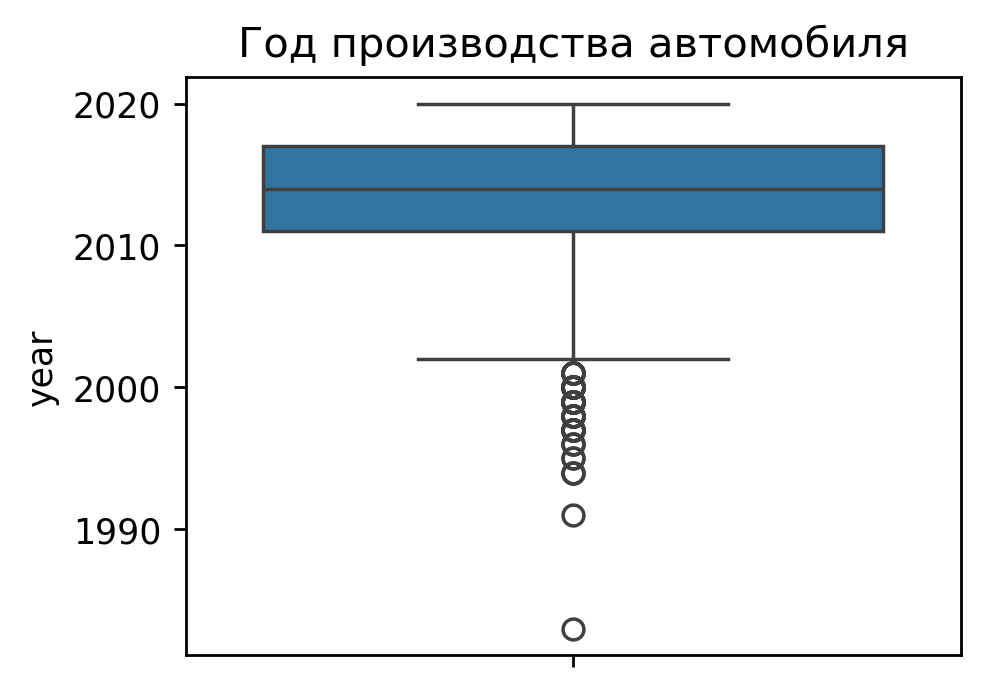

-----------------------------------
count    6.926000e+03
mean     7.399568e+04
std      5.835810e+04
min      1.000000e+00
25%      4.000000e+04
50%      7.000000e+04
75%      1.000000e+05
max      2.360457e+06
Name: km_driven, dtype: float64
-----------------------------------


-----------------------------------
count    6718.000000
mean        5.434653
std         0.984230
min         2.000000
25%         5.000000
50%         5.000000
75%         5.000000
max        14.000000
Name: seats, dtype: float64
-----------------------------------


In [13]:
for col in df_num_columns.drop("selling_price", axis=1).columns:
    print("-----------------------------------")
    print(df_num_columns[col].describe())
    print("-----------------------------------")
    fig = plt.figure(figsize=(4, 3), dpi=250)
    if col in dict_translate_features.keys():
        plt.title(dict_translate_features[col])
        sns.boxplot(data=df_num_columns, y=col)
        plt.show()

In [14]:
#Всего 2 объекта, у которых есть явные выбросы, но такой пробег в реале может быть, поэтому посмотрим ещё график histplot
df_num_columns[df_num_columns["km_driven"]>= 1000000]

year  selling_price  km_driven  seats
1646  2012         500000    1500000    7.0
3161  2007         550000    2360457    5.0

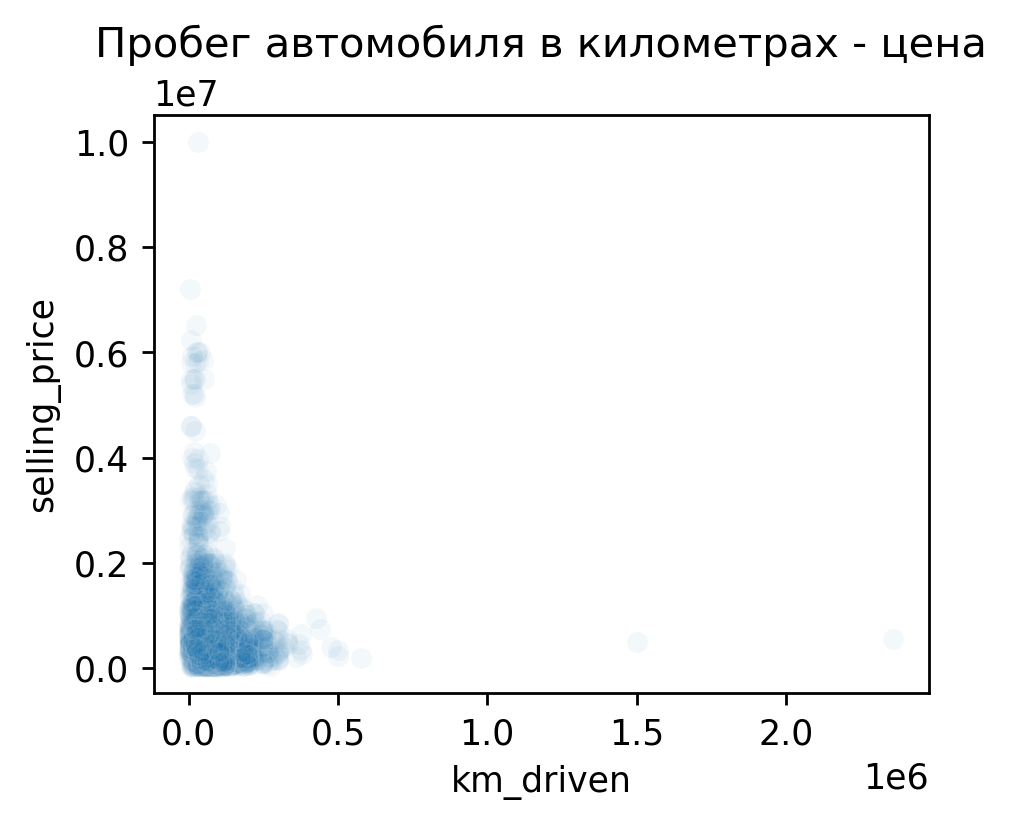

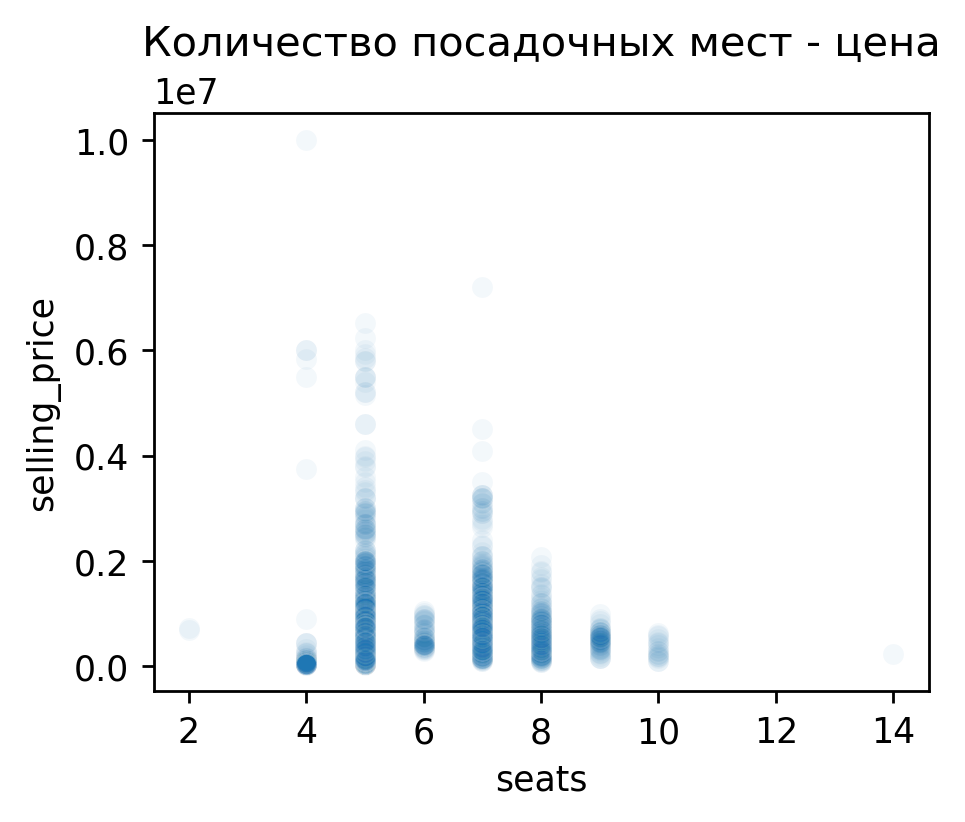

In [15]:
#Посмотрим свяль с целевой переменной с помощью histplot
for col in df_num_columns.drop("selling_price", axis=1).columns:
    fig = plt.figure(figsize=(4, 3), dpi=250)
    plt.title(f"{dict_translate_features[col]} - цена")
    sns.scatterplot(data=df_num_columns, x=col, y="selling_price", alpha=0.05)
    plt.show()

### Заполнение пропусков в вещественных колонках
- Данные с пропуском более 55% будут удалены, так как заполнение их может дать ложные результаты для модели
- Данные с пропуском от 3 до 55% можно заполнить с помощью метода KNN
- Данные с пропусками до 3% можно заполнить модой или средним

In [16]:
#Посмотрим на процентное соотношение 
df_num_columns.isna().sum() / len(df) * 100

year             0.000000
selling_price    0.000000
km_driven        0.000000
seats            3.003176
dtype: float64

In [17]:
#Заполним пропуски seats с помощью метода KNN
fillna_model = KNeighborsRegressor(n_neighbors=5)


not_fill_index = df_num_columns[df_num_columns["seats"].notna()].index
fill_index = df_num_columns[df_num_columns["seats"].isnull()].index
X_train_fillna, y_train_fillna = df_num_columns.iloc[not_fill_index][["year", "km_driven"]], df_num_columns.iloc[not_fill_index]["seats"]

X_missing = df_num_columns.iloc[fill_index][["year", "km_driven"]]

fillna_model.fit(X_train_fillna, y_train_fillna)

predict = np.round(fillna_model.predict(X_missing))
print(f"Количетсво пропусков: {len(predict)}")
df_num_columns.loc[fill_index, "seats"] = predict

Количетсво пропусков: 208


In [18]:
print(f"Всего пропусков: {df_num_columns.isna().sum().sum()}")

Всего пропусков: 0


In [19]:
#Посмотрим распределение с помощью histplot, также посмотрим ассиметрию и эксцесс

for col in df_num_columns.drop("selling_price", axis=1).columns:
    print("---------------------------------------------------")
    print(f"Ассимметрия равна {df_num_columns[col].skew()}")
    print(f"Эксцесс равен {df_num_columns[col].kurt()}")
    print("---------------------------------------------------")
    fig = plt.figure(figsize=(5, 4), dpi=250)
    plt.title(dict_translate_features[col])
    plt.ylabel("Количество")
    sns.histplot(data=df_num_columns, x=col)
    plt.show()

---------------------------------------------------
Ассимметрия равна -1.0109238235669904
Эксцесс равен 1.614733878541498
---------------------------------------------------


---------------------------------------------------
Ассимметрия равна 11.758425539599084
Эксцесс равен 394.08811938521194
---------------------------------------------------


---------------------------------------------------
Ассимметрия равна 1.9242858224950399
Эксцесс равен 3.674062183677662
---------------------------------------------------


In [20]:
#Посмотрим на среднюю цену автомобиля для каждого кода
indexes = sorted(df_num_columns["year"].unique())
fig = plt.figure(figsize=(5, 4), dpi=250)
sns.barplot(data=df_num_columns.groupby("year").mean()["selling_price"].loc[indexes].reset_index(), x="year", y="selling_price", palette='hls')
plt.xticks(rotation=50)
plt.show()

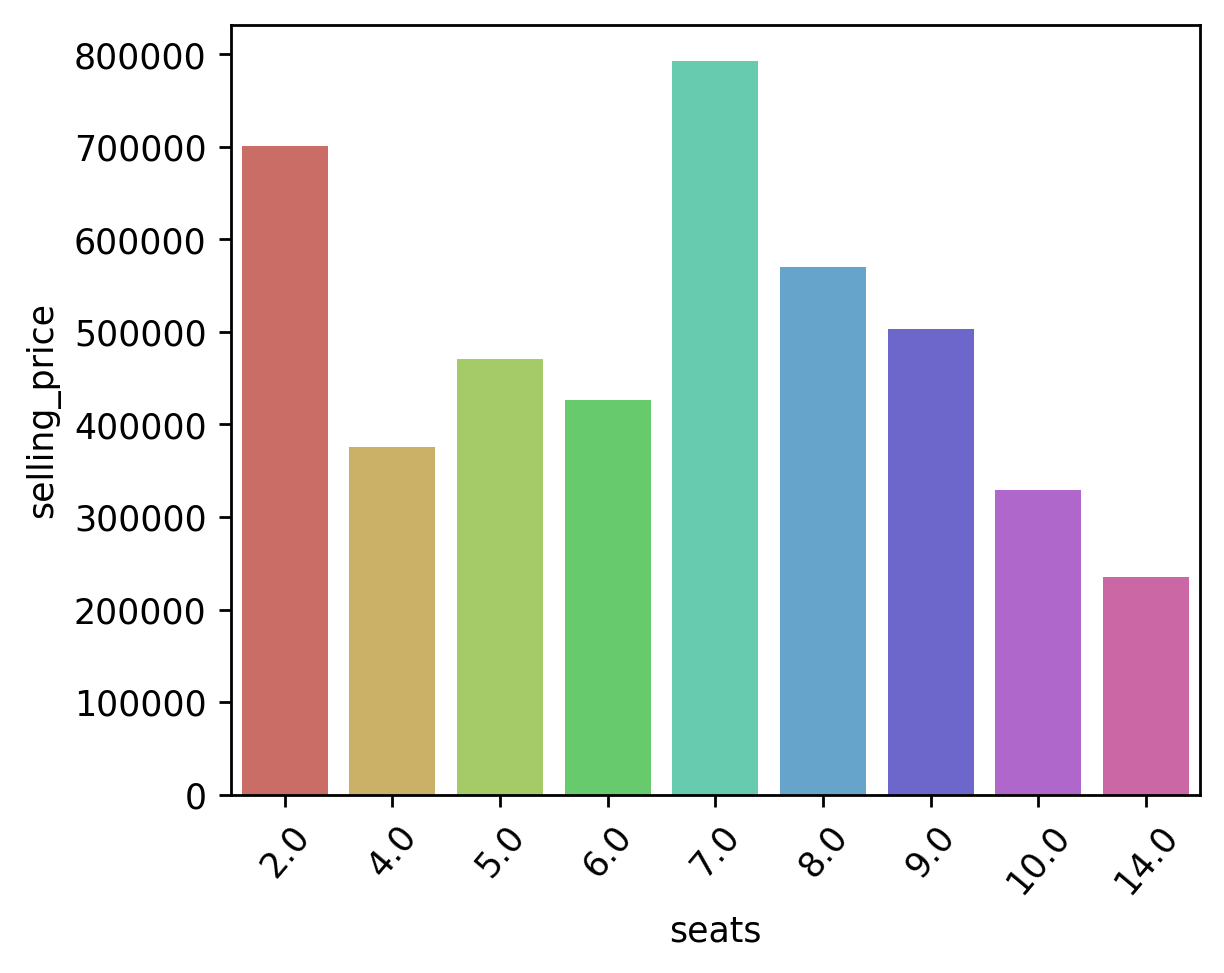

In [21]:
#Посмотрим на среднюю цену автомобиля для каждого кода
indexes = sorted(df_num_columns["seats"].unique())
fig = plt.figure(figsize=(5, 4), dpi=250)
sns.barplot(data=df_num_columns.groupby("seats").mean()["selling_price"].loc[indexes].reset_index(), x="seats", y="selling_price", palette='hls')
plt.xticks(rotation=50)
plt.show()

### Принятые решения
- Прологарифмировать признак km_driven, чтобы распределение стало больше похоже на нормальное

---------------------------------------------------
Ассимметрия равна -1.3251260867130437
Эксцесс равен 5.460312835771383
---------------------------------------------------


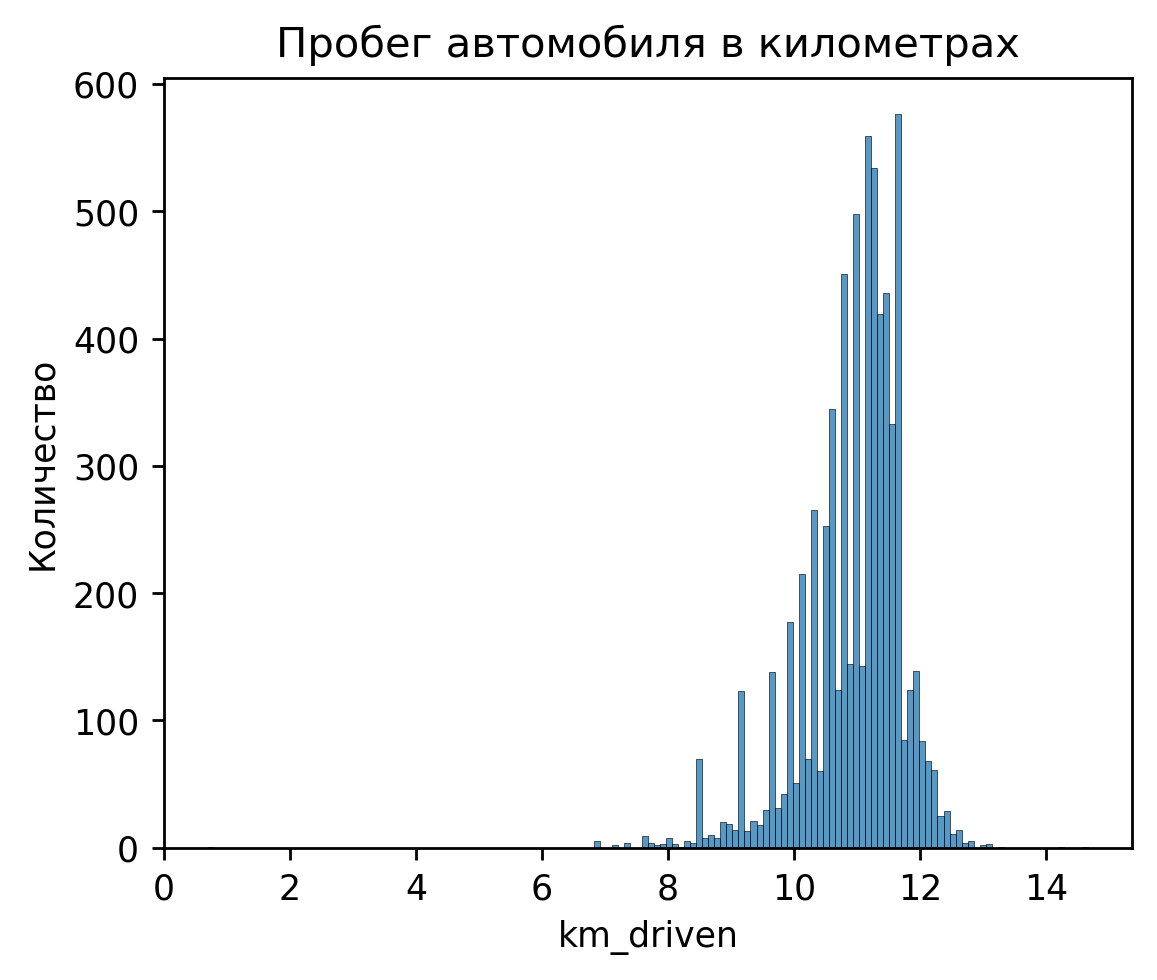

In [22]:
print("---------------------------------------------------")
print(f"Ассимметрия равна {np.log1p(df_num_columns["km_driven"]).skew()}")
print(f"Эксцесс равен {np.log1p(df_num_columns["km_driven"]).kurt()}")
print("---------------------------------------------------")
fig = plt.figure(figsize=(5, 4), dpi=250)
plt.title(dict_translate_features["km_driven"])
plt.ylabel("Количество")
sns.histplot(x=np.log1p(df_num_columns["km_driven"]))
plt.show()

In [23]:
#Прологарифмируем признак km_driven
df_num_columns["km_driven"] = np.log1p(df_num_columns["km_driven"])
print("Признак km_driven успешно прологарифмирован!")

Признак km_driven успешно прологарифмирован!


### Анализ целевой переменной

In [24]:
#Посмотрим на распределеине целевой переменной
print("---------------------------------------------------")
print(f"Ассимметрия равна {df_num_columns["selling_price"].skew()}")
print(f"Эксцесс равен {df_num_columns["selling_price"].kurt()}")
print("---------------------------------------------------")
fig = plt.figure(figsize=(5, 4), dpi=250)
plt.title(dict_translate_features["selling_price"])
plt.ylabel("Количество")
sns.histplot(x=df_num_columns["selling_price"])
plt.show()

---------------------------------------------------
Ассимметрия равна 5.572742292649192
Эксцесс равен 52.82276601297473
---------------------------------------------------


In [25]:
#Посмотрим на распределеине целевой переменной после логарифмирования
print("---------------------------------------------------")
print(f"Ассимметрия равна {np.log1p(df_num_columns["selling_price"]).skew()}")
print(f"Эксцесс равен {np.log1p(df_num_columns["selling_price"]).kurt()}")
print("---------------------------------------------------")
fig = plt.figure(figsize=(5, 4), dpi=250)
plt.title(dict_translate_features["selling_price"])
plt.ylabel("Количество")
sns.histplot(x=np.log1p(df_num_columns["selling_price"]), bins=100)
plt.show()

---------------------------------------------------
Ассимметрия равна -0.1567962527166043
Эксцесс равен 0.7050003307212669
---------------------------------------------------


### Результат
- Распределение очень сильно стало похоже на нормальное, что нам и нужно

In [26]:
#Прологарифмируем признак selling_price
df_num_columns["selling_price"] = np.log1p(df_num_columns["selling_price"])
print("Признак selling_price успешно прологарифмирован!")

Признак selling_price успешно прологарифмирован!


### Анализ мультиколлениарности признаков

In [27]:
#Посмотрим мультиколлениарность, через тепловую карту
fig = plt.figure(figsize=(4, 3), dpi=250)
sns.heatmap(df_num_columns.corr(), annot=True, linewidths=2)
plt.show()

In [28]:
#Проанализируем фактор инфляции дисперсии
#Напишем собственную функцию
def check_VIF(df):
    dict_VIF = {}
    for col in df.columns:
        X_train, y_train = df.drop(col, axis=1), df[col]
        model = LinearRegression()
        model.fit(X_train, y_train)
        R_2 = 1 - (MSE(y_train, model.predict(X_train)) / y_train.var())
        VIF = round(1 / (1 - R_2), 3)
        dict_VIF[col] = VIF
    print(pd.DataFrame(index=dict_VIF.keys(), data=dict_VIF.values(), columns=["VIF"]))

In [29]:
check_VIF(df_num_columns.drop("selling_price", axis=1))

             VIF
year       1.349
km_driven  1.403
seats      1.066


# Результат
- Между попарными признаками линейная зависимость ненаблюдается
- Между признаками и целевой переменной есть не плохая линейная зависимость
- Функция VIF показала, что нет признаков, которые состоят из линейной коомбинации других признаков

### Анализ категориальных признаков

In [30]:
#Посмотрим на основные статистики
df_cat_columns.drop("selling_price", axis=1).describe()

name    fuel seller_type transmission        owner  \
count                     6926    6926        6926         6926         6926   
unique                    2058       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       118    3755        6218         6342         4242   

          mileage   engine max_power          torque  
count        6718     6718      6721            6717  
unique        393      121       322             441  
top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
freq          210      907       324             472

In [31]:
df_cat_columns.name

0                  Maruti Swift Dzire VDI
1            Skoda Rapid 1.5 TDI Ambition
2                Honda City 2017-2020 EXi
3               Hyundai i20 Sportz Diesel
4                  Maruti Swift VXI BSIII
                      ...                
6921    Maruti Wagon R VXI BS IV with ABS
6922           Hyundai i20 Magna 1.4 CRDi
6923                    Hyundai i20 Magna
6924                Hyundai Verna CRDi SX
6925               Maruti Swift Dzire ZDi
Name: name, Length: 6926, dtype: object

In [32]:
df_cat_columns.name.apply(lambda x: x.split()[0]).value_counts()

name
Maruti           2165
Hyundai          1267
Mahindra          723
Tata              647
Honda             362
Ford              361
Toyota            357
Chevrolet         216
Renault           206
Volkswagen        174
Nissan             73
Skoda              70
Datsun             57
BMW                47
Mercedes-Benz      46
Fiat               44
Audi               33
Jeep               22
Mitsubishi         11
Volvo               9
Jaguar              8
Isuzu               4
Force               4
Ambassador          4
Daewoo              3
MG                  3
Land                3
Kia                 3
Lexus               1
Ashok               1
Opel                1
Peugeot             1
Name: count, dtype: int64

In [33]:
#Создамим признак brand, а признак name удалим
df_cat_columns["brand"] = df_cat_columns.name.apply(lambda x: x.split()[0])
df_cat_columns.drop("name", axis=1, inplace=True)
print("Признак name успешно удалён!")

Признак name успешно удалён!


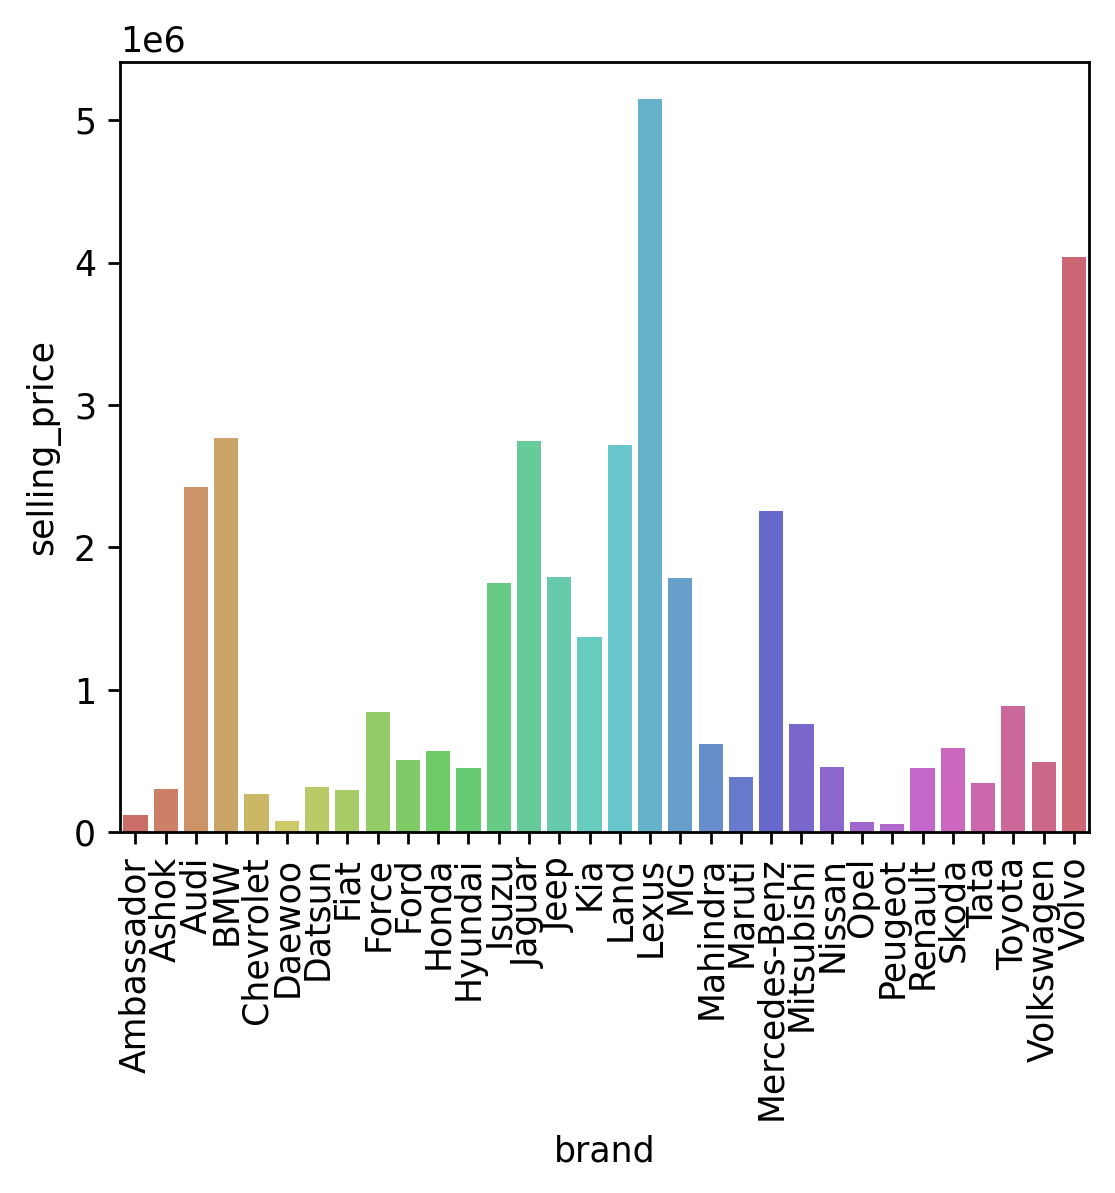

In [34]:
fig = plt.figure(figsize=(5, 4), dpi=250)
sns.barplot(data=df_cat_columns.groupby("brand")["selling_price"].mean(), palette="hls")
plt.xticks(rotation = 90)
plt.show()

In [35]:
#Посмотрим на основные статистики
df_cat_columns.drop("selling_price", axis=1).describe()

fuel seller_type transmission        owner    mileage   engine  \
count     6926        6926         6926         6926       6718     6718   
unique       4           3            2            5        393      121   
top     Diesel  Individual       Manual  First Owner  18.9 kmpl  1248 CC   
freq      3755        6218         6342         4242        210      907   

       max_power          torque   brand  
count       6721            6717    6926  
unique       322             441      32  
top       74 bhp  190Nm@ 2000rpm  Maruti  
freq         324             472    2165

### Заполним пропуски с помощью метода KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier

for col in ["mileage", "engine", "max_power", "torque"]:
    fillna_model = KNeighborsClassifier(n_neighbors=5)
    not_fill_index = df_cat_columns[df_cat_columns[col].notna()].index
    fill_index = df_cat_columns[df_cat_columns[col].isnull()].index

    X_train_fillna, y_train_fillna = df_num_columns.iloc[not_fill_index][["year", "km_driven", "seats"]], df_cat_columns.iloc[not_fill_index][col]

    X_missing = df_num_columns.iloc[fill_index][["year", "km_driven", "seats"]]

    fillna_model.fit(X_train_fillna, y_train_fillna)

    predict = fillna_model.predict(X_missing)
    print(f"Количетсво пропусков: {len(predict)}")
    df_cat_columns.loc[fill_index, col] = predict

Количетсво пропусков: 208
Количетсво пропусков: 208
Количетсво пропусков: 205
Количетсво пропусков: 209


In [37]:
print(f"Общее количество пропусков: {df_cat_columns.isna().sum().sum()}")

Общее количество пропусков: 0


### Описание признаков
 - **mileage** - Расход топлива
 - **engine** - Объем двигателя в кубических сантиметрах
 - **max_power** -  Максимальная мощность в лошадиных силах
 - **torque** - Крутящий момент

##### Все данные признаки потенциально являются вещественными, нужно их раскодировать

##### Но для начала нужно заполнить пропуски в данных колонках с помощью KNN

In [38]:
#Расмотрим признак mileage - Расход топлива
df_cat_columns["mileage"] = df_cat_columns["mileage"].apply(lambda x: x.split()[0]).astype("float")
df_cat_columns["mileage"].head()

0    23.40
1    21.14
2    17.70
3    23.00
4    16.10
Name: mileage, dtype: float64

In [39]:
df[df_cat_columns["mileage"] == 0].shape[0]

17

In [40]:
#Расмотрим признак engine - Объем двигателя в кубических сантиметрах
df_cat_columns["engine"] = df_cat_columns["engine"].apply(lambda x: x.split()[0]).astype("int")
df_cat_columns["engine"].head()

0    1248
1    1498
2    1497
3    1396
4    1298
Name: engine, dtype: int64

In [41]:
df[df_cat_columns["engine"] == 0].shape[0]

0

In [42]:
def max_power_encoding(string):
    if string.split()[0] != "bhp":
        return string.split()[0]
    else:
        return 0

In [43]:
#Расмотрим признак max_power - Максимальная мощность в лошадиных силах
df_cat_columns["max_power"] = df_cat_columns["max_power"].apply(max_power_encoding).astype("float")
df_cat_columns["max_power"].head()

0     74.00
1    103.52
2     78.00
3     90.00
4     88.20
Name: max_power, dtype: float64

In [44]:
df_cat_columns[df_cat_columns["max_power"] == 0].shape[0]

8

In [45]:
df_cat_columns["torque"].head()

0              190Nm@ 2000rpm
1         250Nm@ 1500-2500rpm
2       12.7@ 2,700(kgm@ rpm)
3    22.4 kgm at 1750-2750rpm
4       11.5@ 4,500(kgm@ rpm)
Name: torque, dtype: object

### Анализ
- Нужно провести раскодировку признака torque
- В данном признаке можно выделить Крутящий момент и обороты в минуту
- Также стоит отметить, что в признаке крутящий момент, выражается, как Nm - в ньютонах, так и kgm - так и в килограммах, так как на земле ускорение свободного падения равна 9.8, то kgm = 9.8 Nm

In [46]:
import numpy as np
import re

def parse_torque(torque_str):
    if not isinstance(torque_str, str):
        return np.nan, np.nan

    torque_str = torque_str.lower()

    torque_match = re.search(r'([\d\.]+)', torque_str)
    if not torque_match:
        return np.nan, np.nan
    
    torque_value = float(torque_match.group(1))

    if 'kgm' in torque_str:
        torque_value *= 9.8

    rpm_match = re.search(r'[\@at]\s*([\d,\-]+)', torque_str)
    if not rpm_match:
        rpm_value = np.nan
    else:
        rpm_str = rpm_match.group(1).replace(',', '')
        if '-' in rpm_str:
            parts = rpm_str.split('-')
            rpm_value = (float(parts[0]) + float(parts[1])) / 2
        else:
            rpm_value = float(rpm_str)
            
    return torque_value, rpm_value


In [47]:
df_cat_columns[["torque_nm", "torque_rpm"]] = df_cat_columns["torque"].apply(parse_torque).apply(pd.Series)
df_cat_columns.drop("torque", axis=1, inplace=True)
print("Признаки torque_nm и torque_rpm были успешно добавлены!")
print("Признак toqrue был удалён!")

Признаки torque_nm и torque_rpm были успешно добавлены!
Признак toqrue был удалён!


In [48]:
df_cat_columns[["torque_nm", "torque_rpm"]].isna().sum()

torque_nm      0
torque_rpm    12
dtype: int64

In [49]:
print(f"Количество нулевых значчений в признаке mileage: {df_cat_columns[df_cat_columns["mileage"]==0].shape[0]}")
print(f"Количество нулевых значчений в признаке max_power: {df_cat_columns[df_cat_columns["max_power"] == 0].shape[0]}")

Количество нулевых значчений в признаке mileage: 17
Количество нулевых значчений в признаке max_power: 8


В признаках mileage - расход топлива и max_power - лошадиные силы есть нулевые значения, такого быть не должно

Заполним значения Nan, после чего заполним KNN

In [50]:
index_mileage = df_cat_columns[df_cat_columns["mileage"]==0].index
index_max_power = df_cat_columns[df_cat_columns["max_power"]==0].index
df_cat_columns.loc[index_mileage, "mileage"] = np.nan
df_cat_columns.loc[index_max_power, "max_power"] = np.nan

In [51]:
df_cat_columns.isna().sum()

fuel              0
seller_type       0
transmission      0
owner             0
mileage          17
engine            0
max_power         8
selling_price     0
brand             0
torque_nm         0
torque_rpm       12
dtype: int64

In [52]:
#Заполним оставшиеся пропуски
for col in ["mileage", "max_power", "torque_rpm"]:
    fillna_model = KNeighborsRegressor(n_neighbors=5)
    not_fill_index = df_cat_columns[df_cat_columns[col].notna()].index
    fill_index = df_cat_columns[df_cat_columns[col].isnull()].index

    X_train_fillna, y_train_fillna = df_num_columns.iloc[not_fill_index][["year", "km_driven", "seats"]], df_cat_columns.iloc[not_fill_index][col]

    X_missing = df_num_columns.iloc[fill_index][["year", "km_driven", "seats"]]

    fillna_model.fit(X_train_fillna, y_train_fillna)

    predict = fillna_model.predict(X_missing)
    print(f"Количетсво пропусков: {len(predict)}")
    df_cat_columns.loc[fill_index, col] = predict

Количетсво пропусков: 17
Количетсво пропусков: 8
Количетсво пропусков: 12


In [53]:
print(f"Сумарное количество пропусков: {df_cat_columns.isna().sum().sum()}")

Сумарное количество пропусков: 0


In [54]:
df_cat_columns.drop("selling_price", axis=1).dtypes

fuel             object
seller_type      object
transmission     object
owner            object
mileage         float64
engine            int64
max_power       float64
brand            object
torque_nm       float64
torque_rpm      float64
dtype: object

In [55]:
#Перетащим вещественные признаки в df_num_columns
df_num_columns = pd.concat([df_num_columns, df_cat_columns[["mileage", "max_power", "torque_nm", "torque_rpm", "engine"]]], axis=1)
df_cat_columns.drop(["mileage", "max_power", "torque_nm", "torque_rpm", "engine"], axis=1, inplace=True)

### Посмотрим распределение категориальных признаков

In [56]:
#Обновим список
dict_translate_features = {
    "brand": "Полное название модели автомобиля",
    "year" : "Год производства автомобиля",
    "selling_price": "Целевая переменная - цена",
    "km_driven": "Пробег автомобиля в километрах",
    "fuel": "Тип топлива",
    "seller_type": "Тип продавца",
    "transmission": "Тип коробки передач",
    "owner": "Какой по счету владелец",
    "mileage": " Расход топлива",
    "engine": "Объем двигателя в кубических сантиметрах",
    "max_power": "Максимальная мощность в лошадиных силах",
    "torque_nm": "Крутящий момент",
    "torque_rpm": "Обороты в минуту",
    "seats": "Количество посадочных мест"
}

fuel
Diesel    54.215998
Petrol    44.426798
CNG        0.808548
LPG        0.548657
Name: count, dtype: float64


seller_type
Individual          89.777649
Dealer               9.832515
Trustmark Dealer     0.389835
Name: count, dtype: float64


transmission
Manual       91.568005
Automatic     8.431995
Name: count, dtype: float64


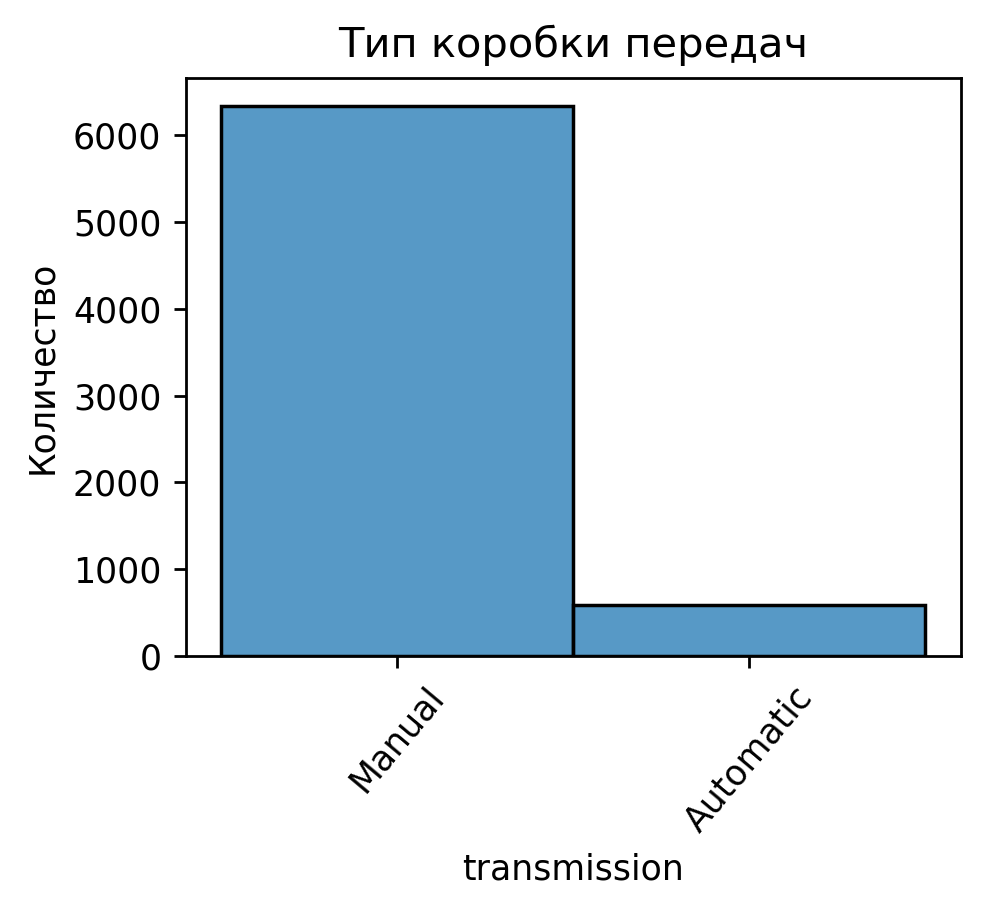

owner
First Owner             61.247473
Second Owner            28.501299
Third Owner              7.738955
Fourth & Above Owner     2.440081
Test Drive Car           0.072192
Name: count, dtype: float64


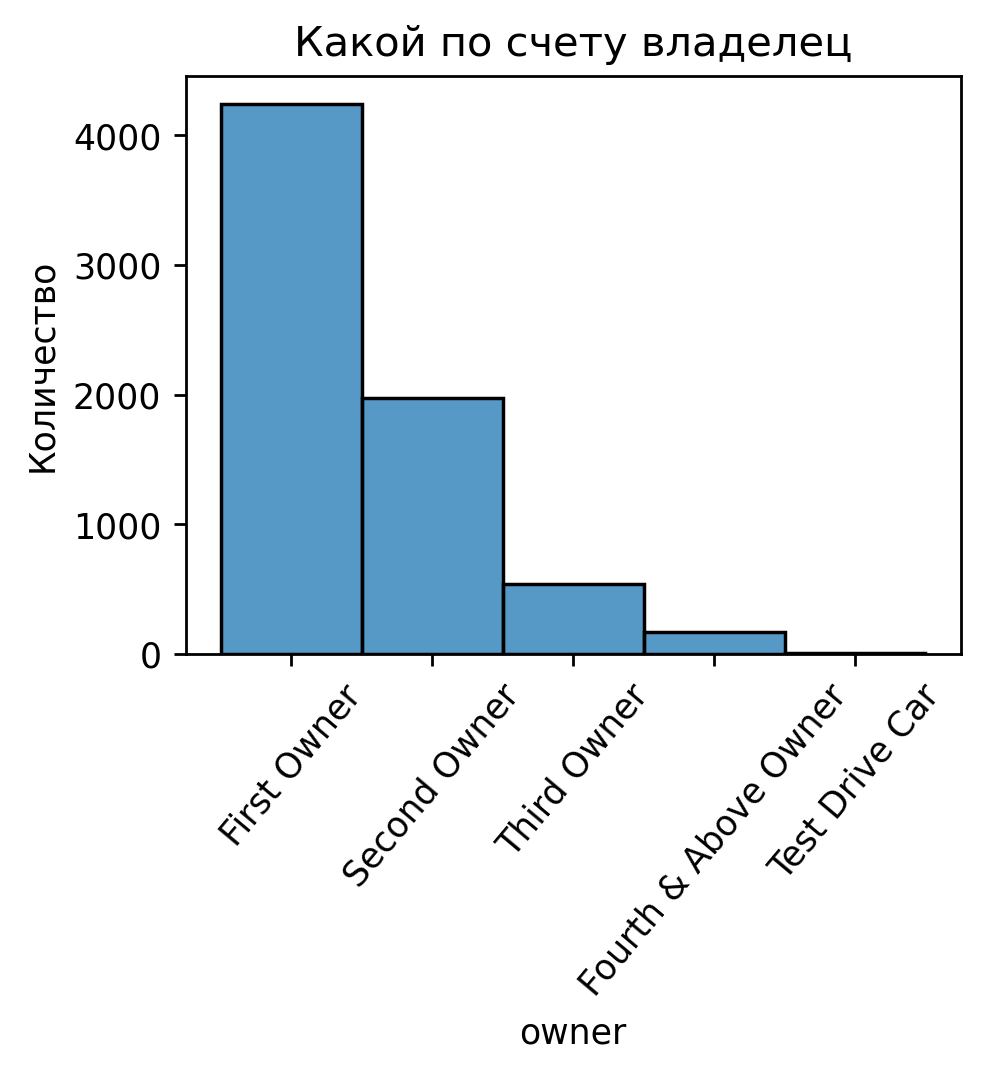

brand
Maruti           31.259024
Hyundai          18.293387
Mahindra         10.438926
Tata              9.341611
Honda             5.226682
Ford              5.212244
Toyota            5.154490
Chevrolet         3.118683
Renault           2.974300
Volkswagen        2.512273
Nissan            1.053999
Skoda             1.010684
Datsun            0.822986
BMW               0.678602
Mercedes-Benz     0.664164
Fiat              0.635287
Audi              0.476465
Jeep              0.317644
Mitsubishi        0.158822
Volvo             0.129945
Jaguar            0.115507
Isuzu             0.057753
Force             0.057753
Ambassador        0.057753
Daewoo            0.043315
MG                0.043315
Land              0.043315
Kia               0.043315
Lexus             0.014438
Ashok             0.014438
Opel              0.014438
Peugeot           0.014438
Name: count, dtype: float64


In [57]:
#Посмотрим распределении категории в категориальных признаках
for col in df_cat_columns.drop("selling_price", axis=1):
    print(df_cat_columns[col].value_counts() / len(df_cat_columns) * 100)
    fig = plt.figure(figsize=(4, 3), dpi=250)
    plt.title(dict_translate_features[col])
    plt.ylabel("Количество")
    sns.histplot(data=df_cat_columns, x=col, palette="hls")
    plt.xticks(rotation=50)
    plt.show()

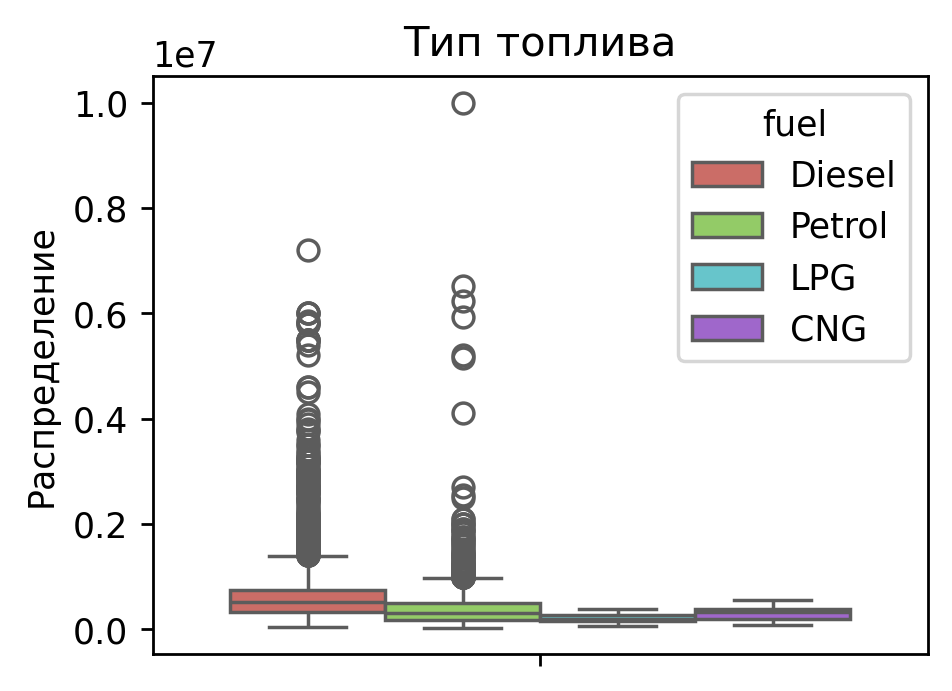

In [58]:
#Посмотрим распределение целевой через разные категории через boxplot
for col in df_cat_columns.drop("selling_price", axis=1):
    fig = plt.figure(figsize=(4, 3), dpi=250)
    plt.title(dict_translate_features[col])
    plt.ylabel("Распределение")
    sns.boxplot(data=df_cat_columns, y="selling_price", palette="hls", hue=col)
    plt.xticks(rotation=50)
    plt.show()

### Анализ 
- Все признаки распределены по разному, значит каждая категория по разному влияет на целевое значение
- Оставляем все признаки

### Закодируем категорильные признаки

In [59]:
df_cat_columns.drop("selling_price", axis=1, inplace=True)
print("Признак selling_price удалён!")

Признак selling_price удалён!


In [60]:
full_df = pd.concat([df_num_columns, df_cat_columns], axis=1)

cv = KFold(n_splits=10, shuffle=True, random_state=42)

for col in ["fuel", "seller_type", "transmission", "owner", "brand"]:
    if full_df[col].nunique() <= 5:
        ohe = pd.get_dummies(data=full_df[col], prefix=col, drop_first=True, dtype="int")
        full_df = pd.concat([full_df, ohe], axis=1)
        full_df.drop(col, axis=1, inplace=True)
    else:
        mte_column = f"{col}_mte"
        full_df[mte_column] = 0.0
        for train_index, val_index in cv.split(full_df):
            map_values = full_df.iloc[train_index].groupby(col)["selling_price"].mean().to_dict()
            mte_values = full_df.loc[val_index, col].map(map_values)

            noise = np.random.uniform(0.99, 1.01, size=len(mte_values))

            full_df.loc[val_index, mte_column] = mte_values * noise

        mean = full_df["selling_price"].mean()
        full_df[mte_column].fillna(mean, inplace=True)

        full_df.drop(col, axis=1, inplace=True)

print("Все признаки были закодированы!")

Все признаки были закодированы!


In [61]:
full_df.dtypes

year                              int64
selling_price                   float64
km_driven                       float64
seats                           float64
mileage                         float64
max_power                       float64
torque_nm                       float64
torque_rpm                      float64
engine                            int64
fuel_Diesel                       int64
fuel_LPG                          int64
fuel_Petrol                       int64
seller_type_Individual            int64
seller_type_Trustmark Dealer      int64
transmission_Manual               int64
owner_Fourth & Above Owner        int64
owner_Second Owner                int64
owner_Test Drive Car              int64
owner_Third Owner                 int64
brand_mte                       float64
dtype: object

In [62]:
print(f"Количество пропусков: {full_df.isna().sum().sum()}")

Количество пропусков: 0


In [63]:
#Загрузим данные 
full_df.to_csv("preprocessing_data_car.csv", sep=";")
print("Данные загружены!")

Данные загружены!


### Снова посмотрим на распределенние, как на вещественных признаков

-----------------------------------
count    6926.000000
mean     2013.420300
std         4.078286
min      1983.000000
25%      2011.000000
50%      2014.000000
75%      2017.000000
max      2020.000000
Name: year, dtype: float64
-----------------------------------


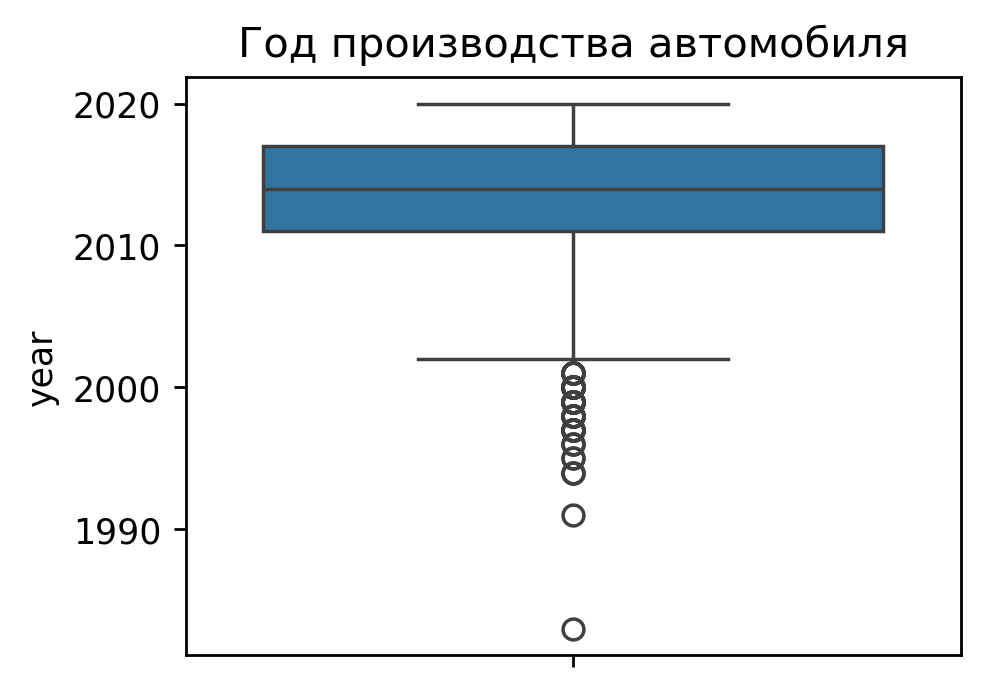

-----------------------------------
count    6926.000000
mean       10.953211
std         0.809847
min         0.693147
25%        10.596660
50%        11.156265
75%        11.512935
max        14.674366
Name: km_driven, dtype: float64
-----------------------------------


-----------------------------------
count    6926.000000
mean        5.431418
std         0.975581
min         2.000000
25%         5.000000
50%         5.000000
75%         5.000000
max        14.000000
Name: seats, dtype: float64
-----------------------------------


-----------------------------------
count    6926.000000
mean       19.400207
std         3.967821
min         9.000000
25%        16.550000
50%        19.300000
75%        22.320000
max        42.000000
Name: mileage, dtype: float64
-----------------------------------


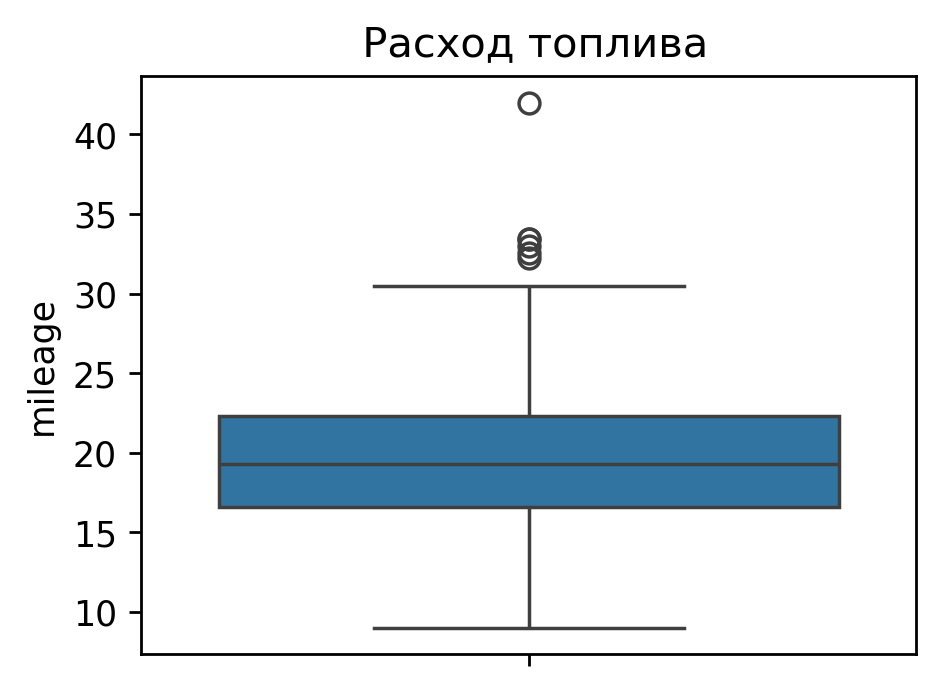

-----------------------------------
count    6926.000000
mean       87.934277
std        32.187942
min        32.800000
25%        67.100000
50%        81.845000
75%       100.000000
max       400.000000
Name: max_power, dtype: float64
-----------------------------------


-----------------------------------
count    6926.000000
mean      173.765293
std       114.312918
min        47.040000
25%       110.000000
50%       160.000000
75%       200.000000
max      3724.000000
Name: torque_nm, dtype: float64
-----------------------------------


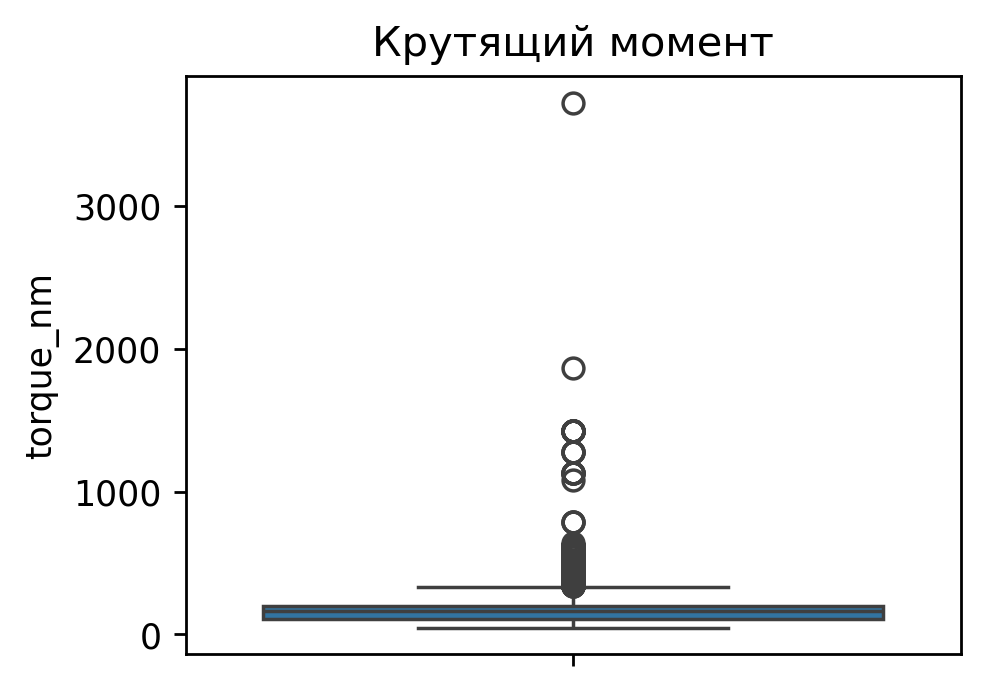

-----------------------------------
count     6926.000000
mean      2878.634926
std        978.979820
min       1300.000000
25%       2000.000000
50%       2500.000000
75%       4000.000000
max      21800.000000
Name: torque_rpm, dtype: float64
-----------------------------------


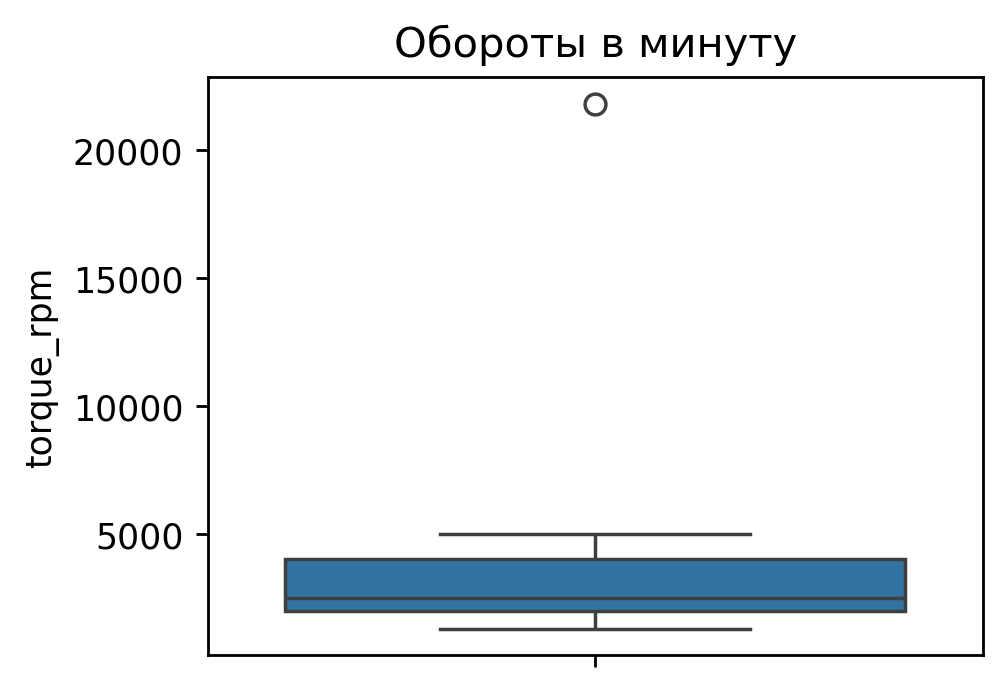

-----------------------------------
count    6926.000000
mean     1425.962749
std       492.597038
min       624.000000
25%      1196.000000
50%      1248.000000
75%      1498.000000
max      3604.000000
Name: engine, dtype: float64
-----------------------------------


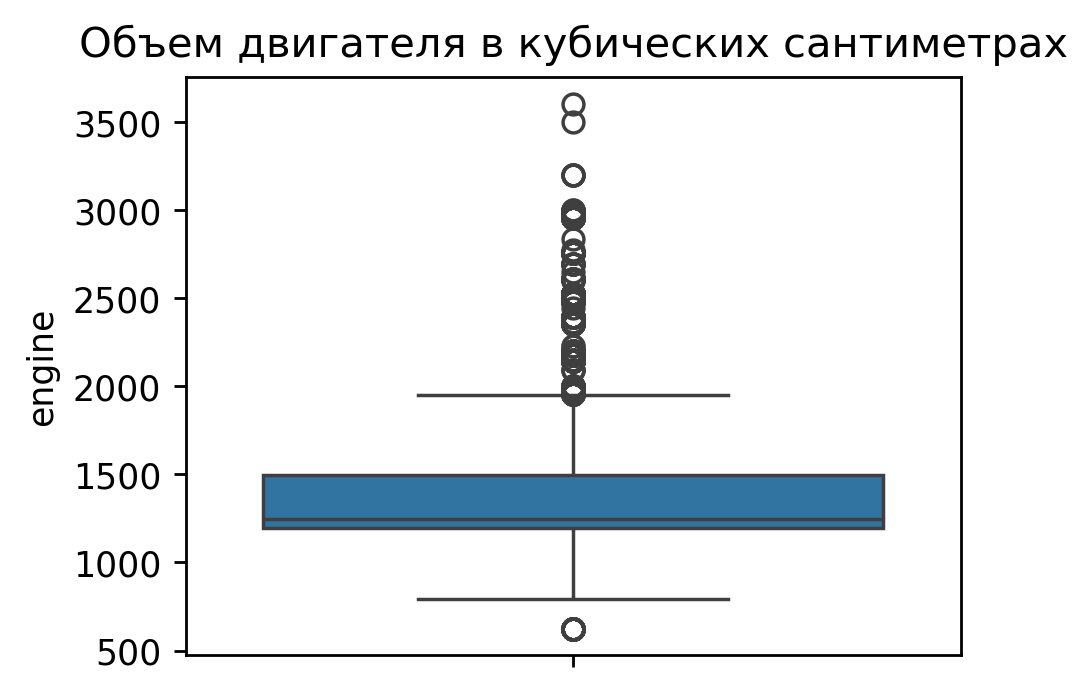

In [64]:
for col in df_num_columns.drop("selling_price", axis=1).columns:
    print("-----------------------------------")
    print(df_num_columns[col].describe())
    print("-----------------------------------")
    fig = plt.figure(figsize=(4, 3), dpi=250)
    if col in dict_translate_features.keys():
        plt.title(dict_translate_features[col])
        sns.boxplot(data=df_num_columns, y=col)
        plt.show()

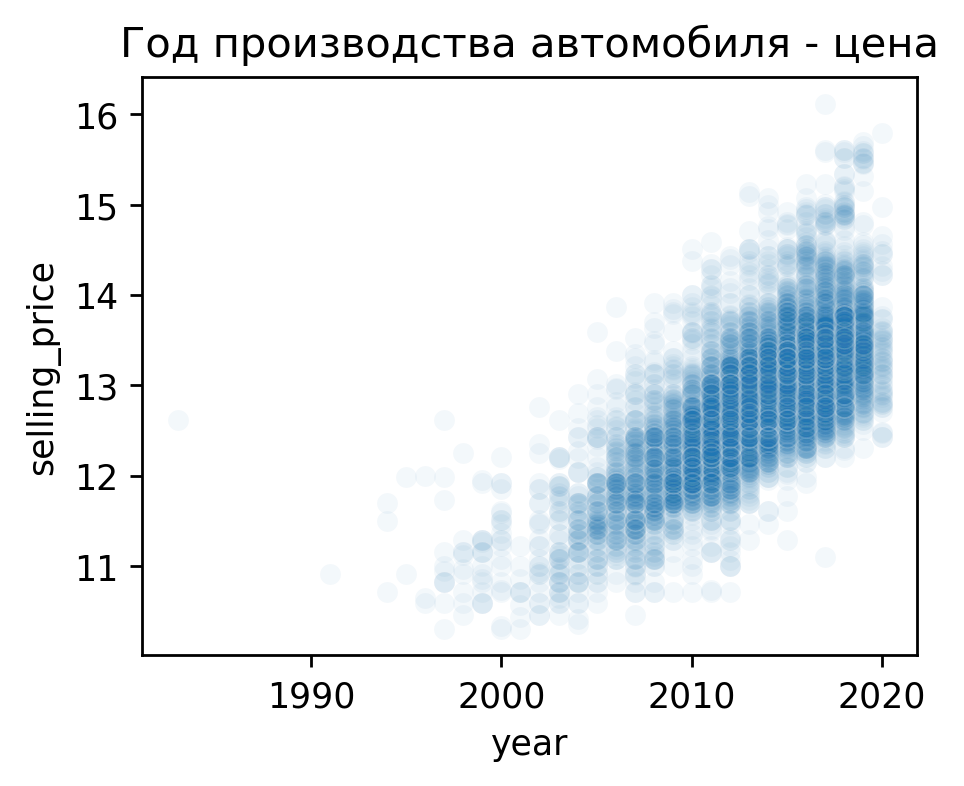

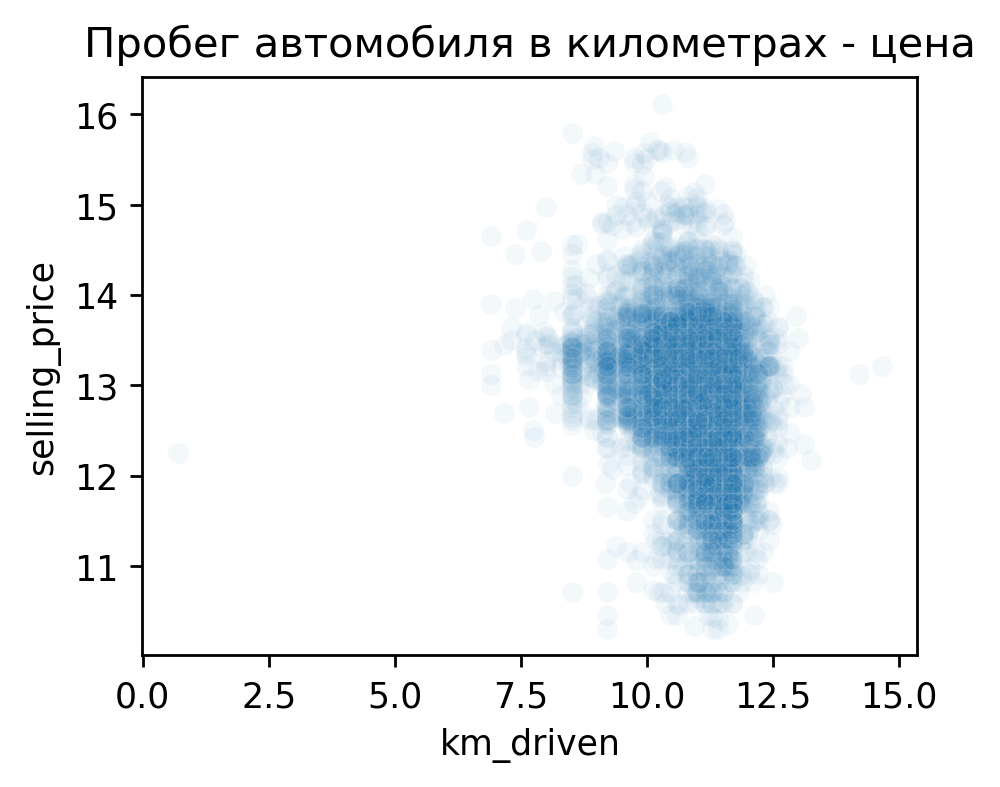

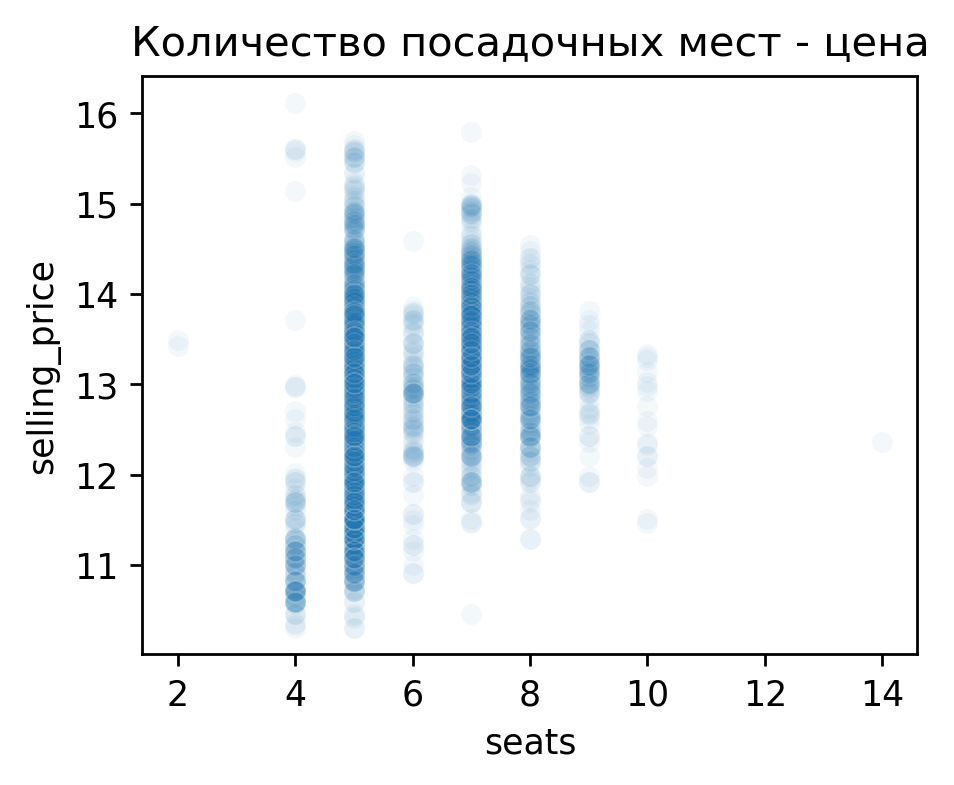

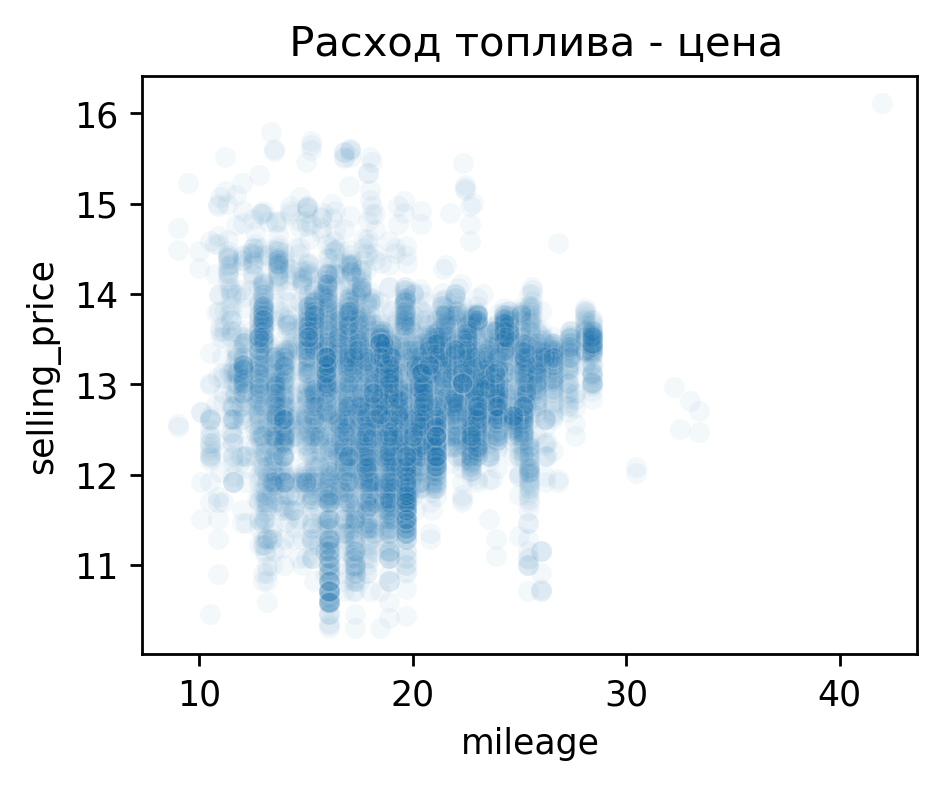

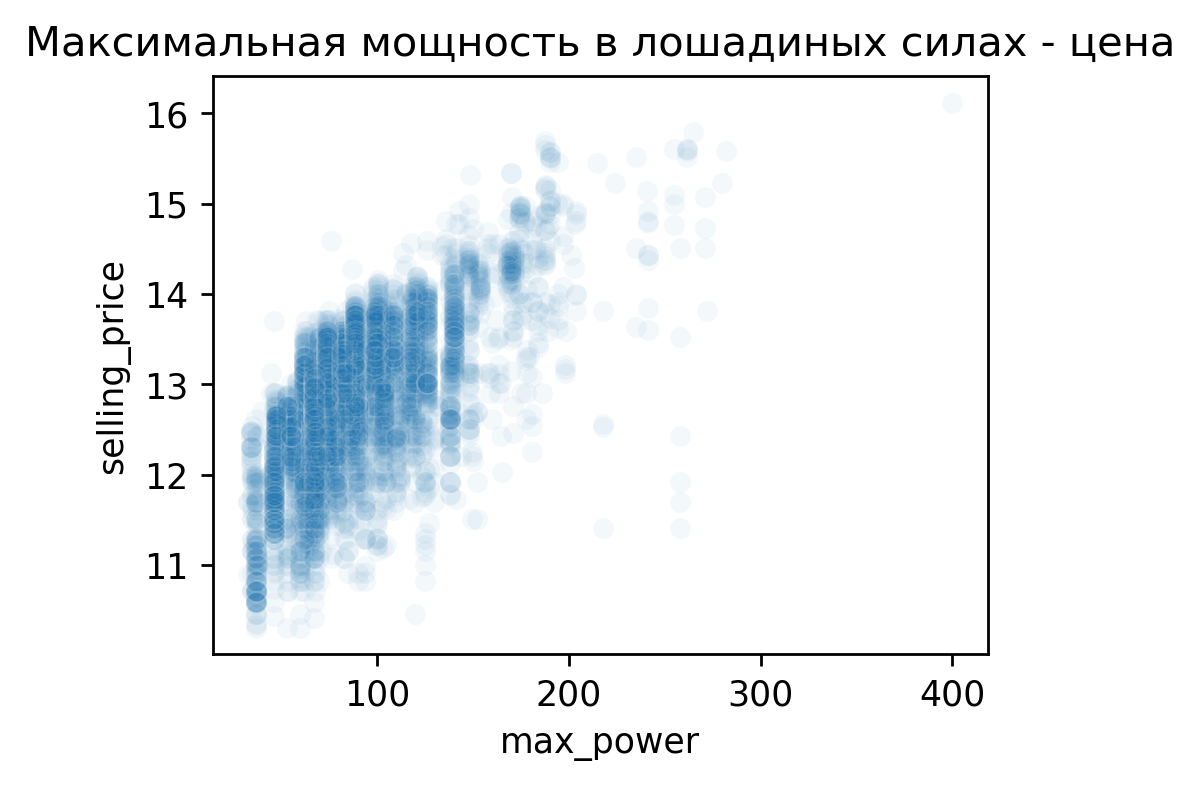

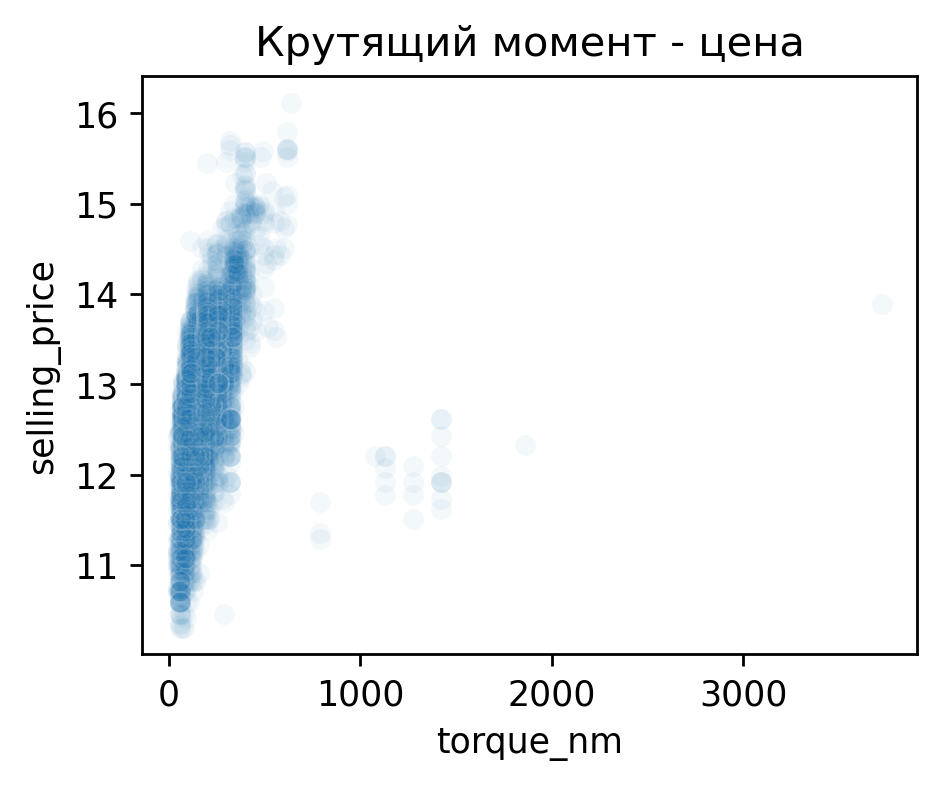

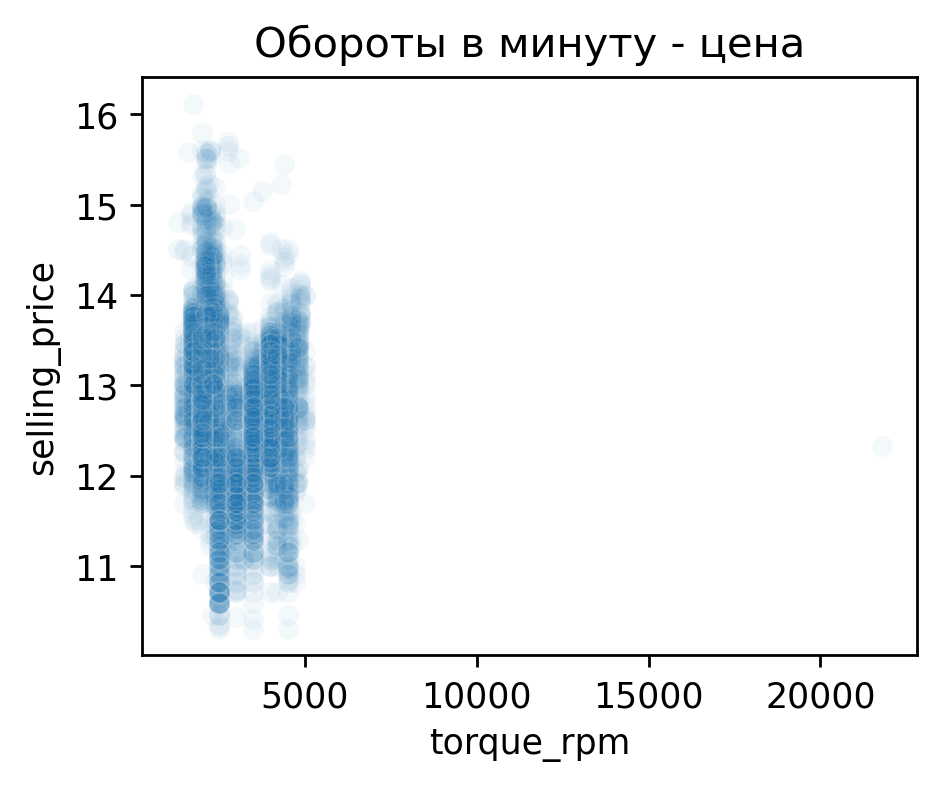

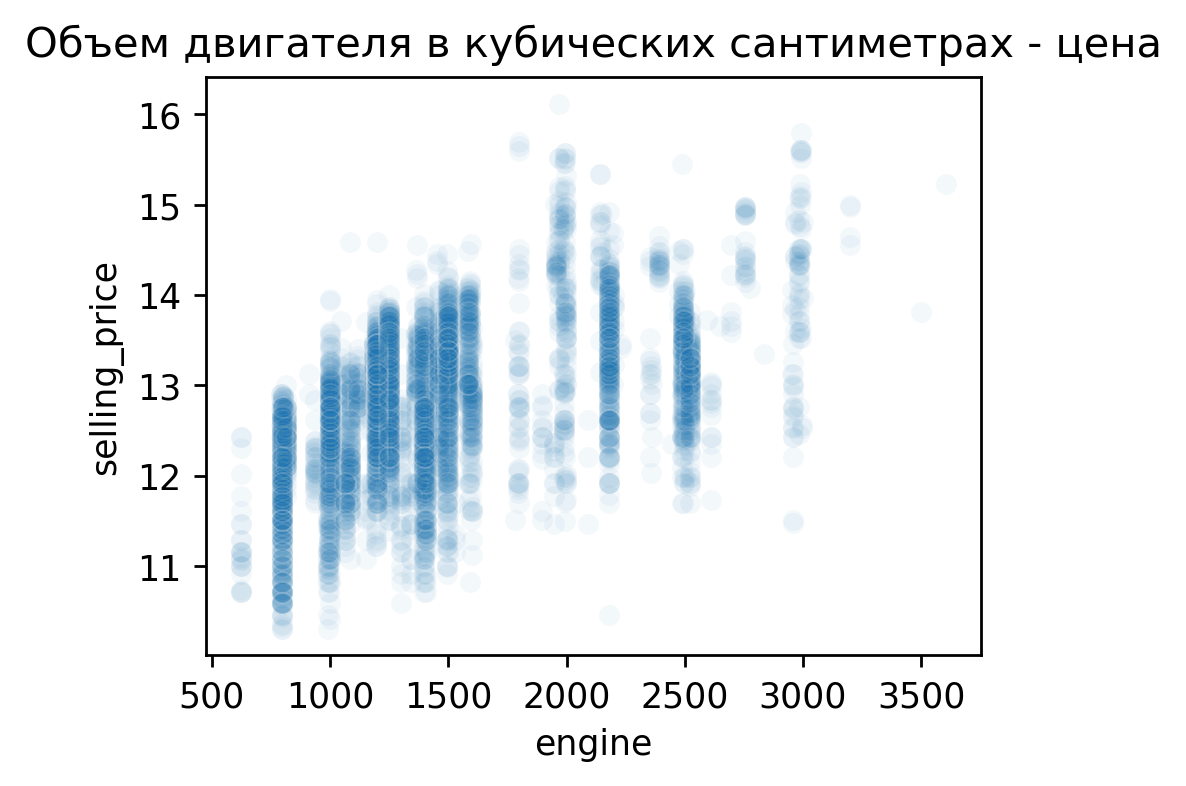

In [65]:
#Посмотрим свяль с целевой переменной с помощью histplot
for col in df_num_columns.drop("selling_price", axis=1).columns:
    fig = plt.figure(figsize=(4, 3), dpi=250)
    plt.title(f"{dict_translate_features[col]} - цена")
    sns.scatterplot(data=df_num_columns, x=col, y="selling_price", alpha=0.05)
    plt.show()

---------------------------------------------------
Ассимметрия равна -1.0109238235669904
Эксцесс равен 1.614733878541498
---------------------------------------------------


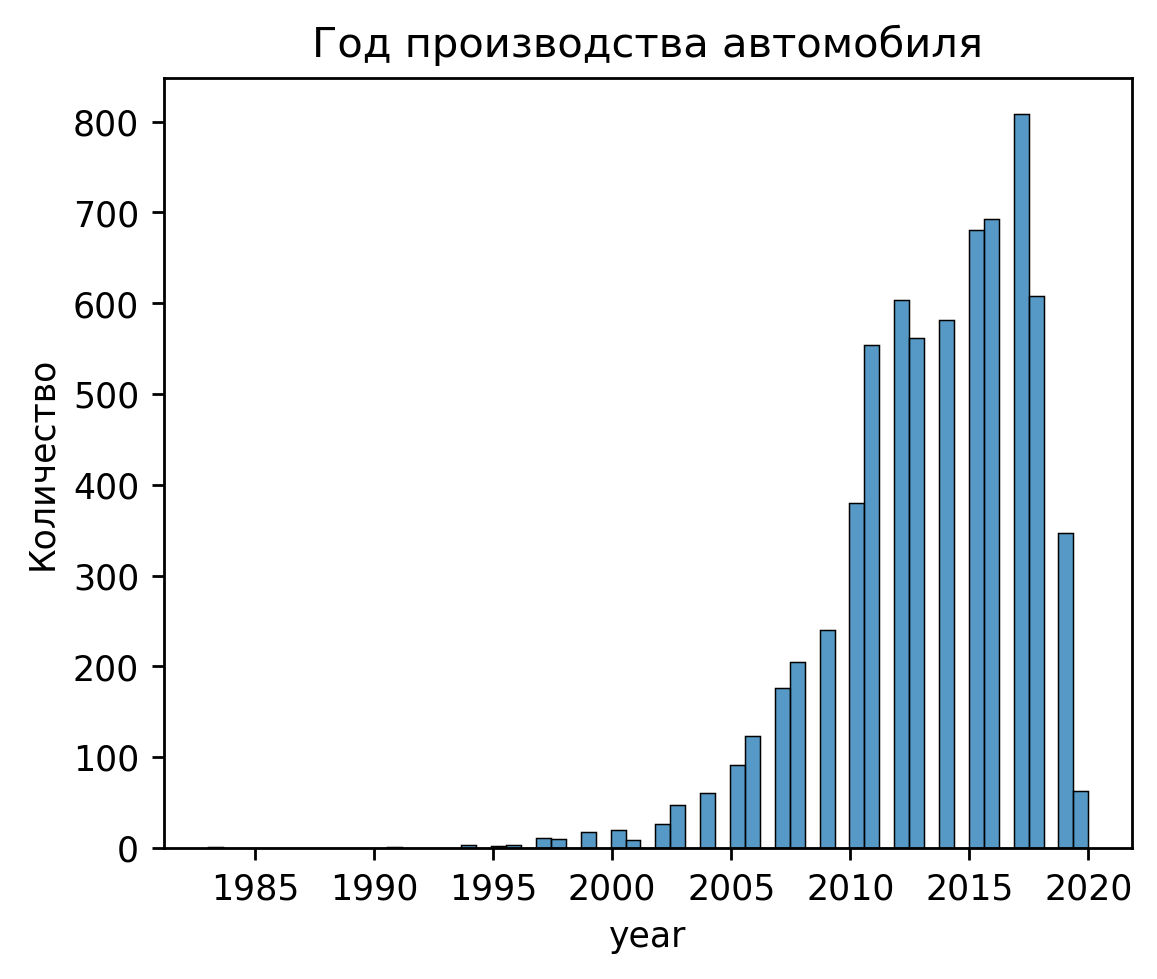

---------------------------------------------------
Ассимметрия равна -1.3251260867130437
Эксцесс равен 5.460312835771383
---------------------------------------------------


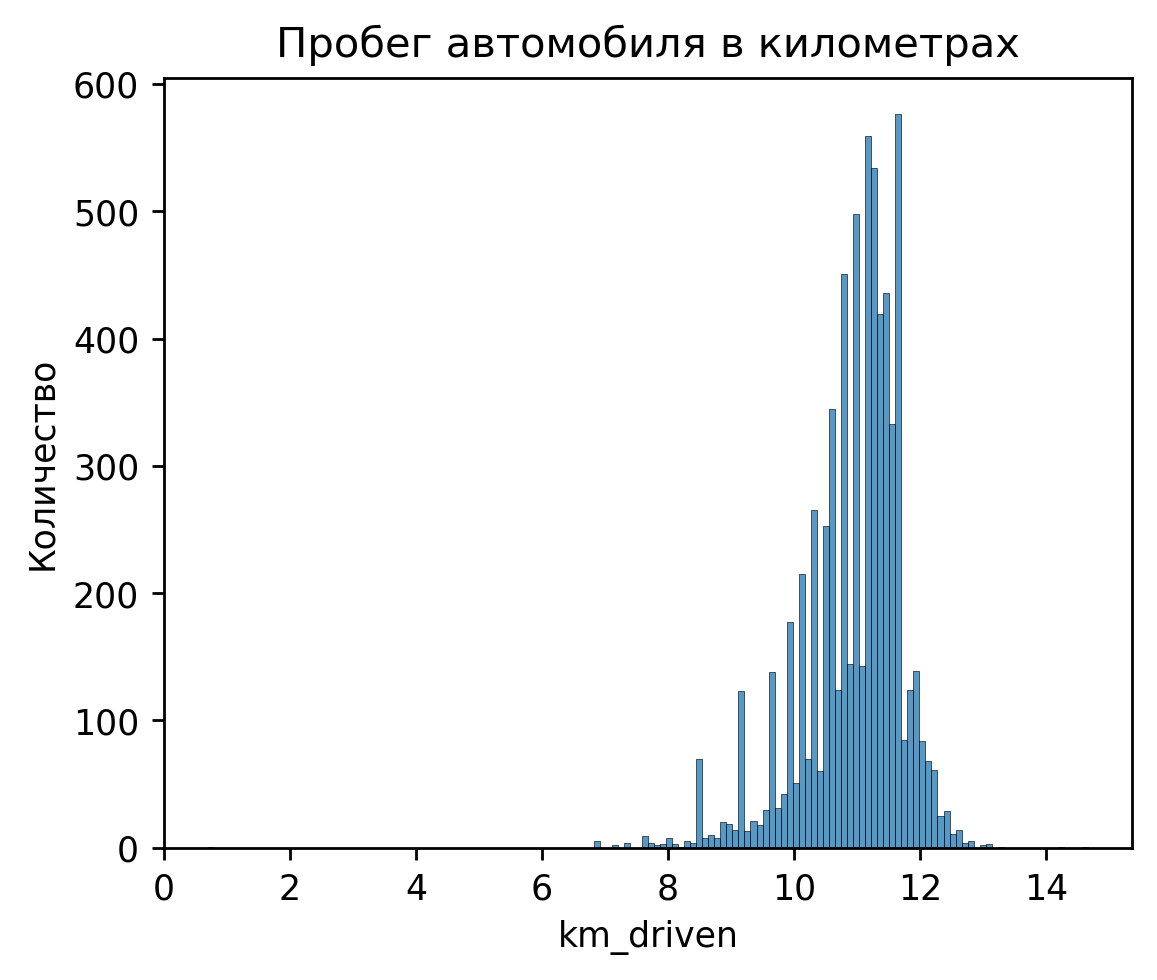

---------------------------------------------------
Ассимметрия равна 1.9242858224950399
Эксцесс равен 3.674062183677662
---------------------------------------------------


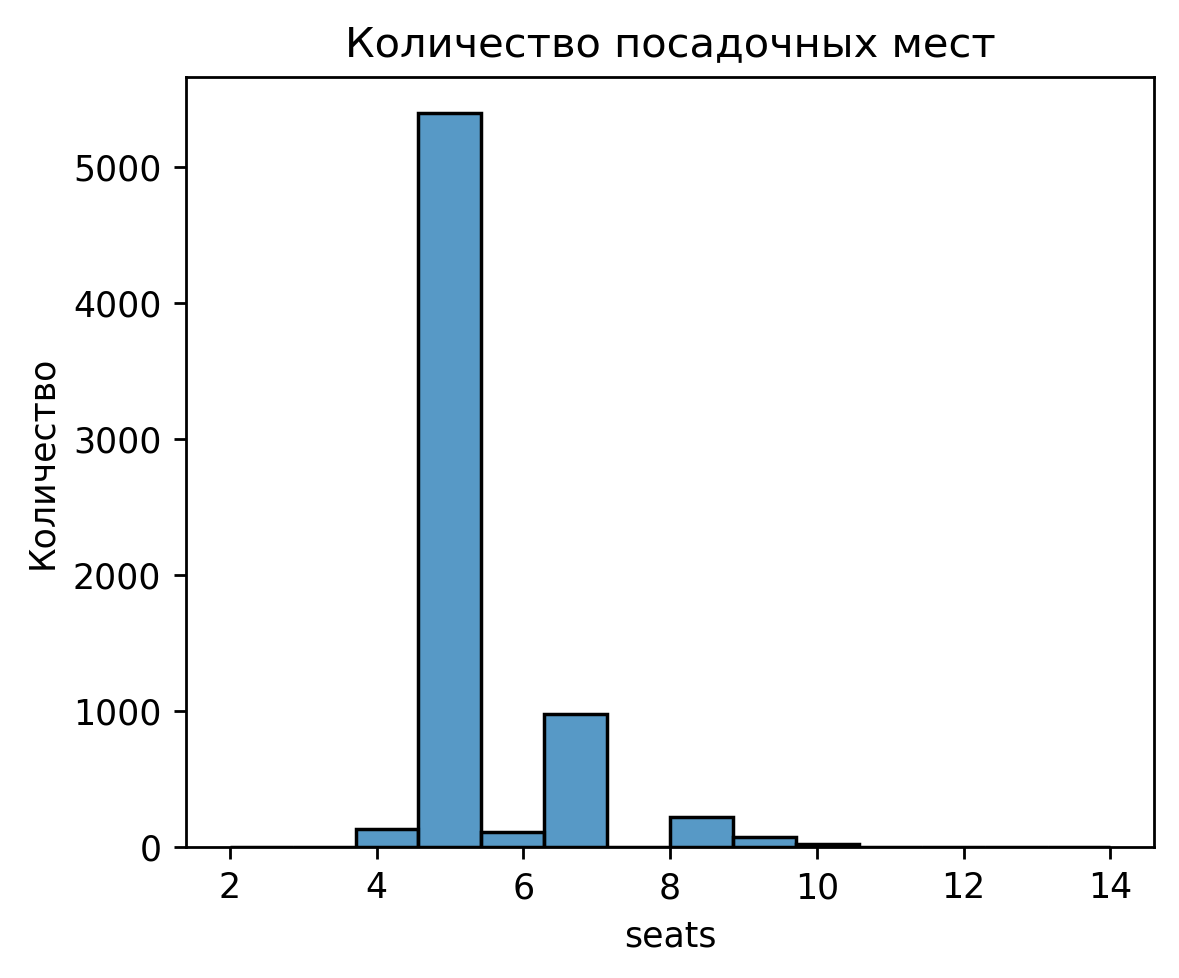

---------------------------------------------------
Ассимметрия равна 0.06589633904806433
Эксцесс равен -0.3336439735617249
---------------------------------------------------


---------------------------------------------------
Ассимметрия равна 1.691077286096642
Эксцесс равен 5.284507402419807
---------------------------------------------------


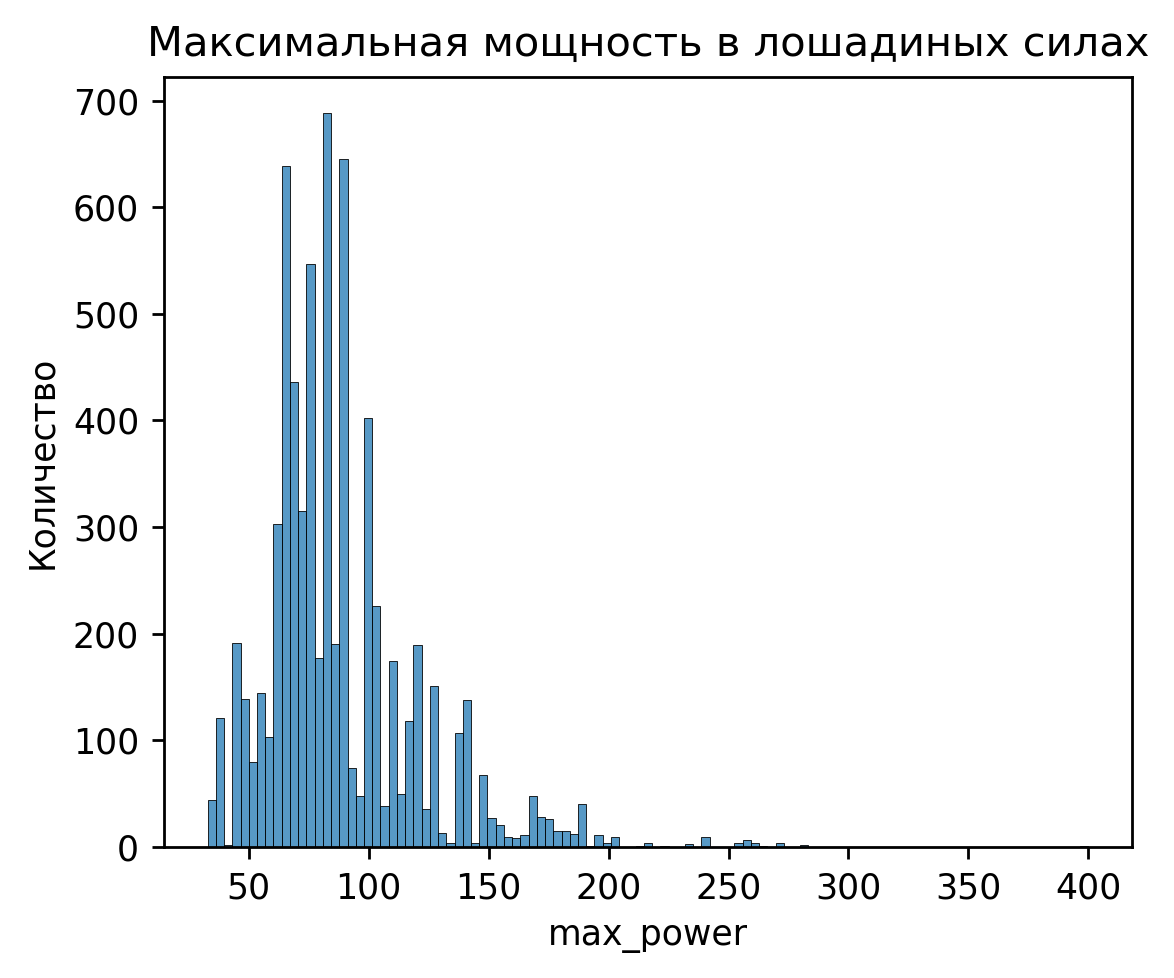

---------------------------------------------------
Ассимметрия равна 8.158969995702204
Эксцесс равен 169.68391544252444
---------------------------------------------------


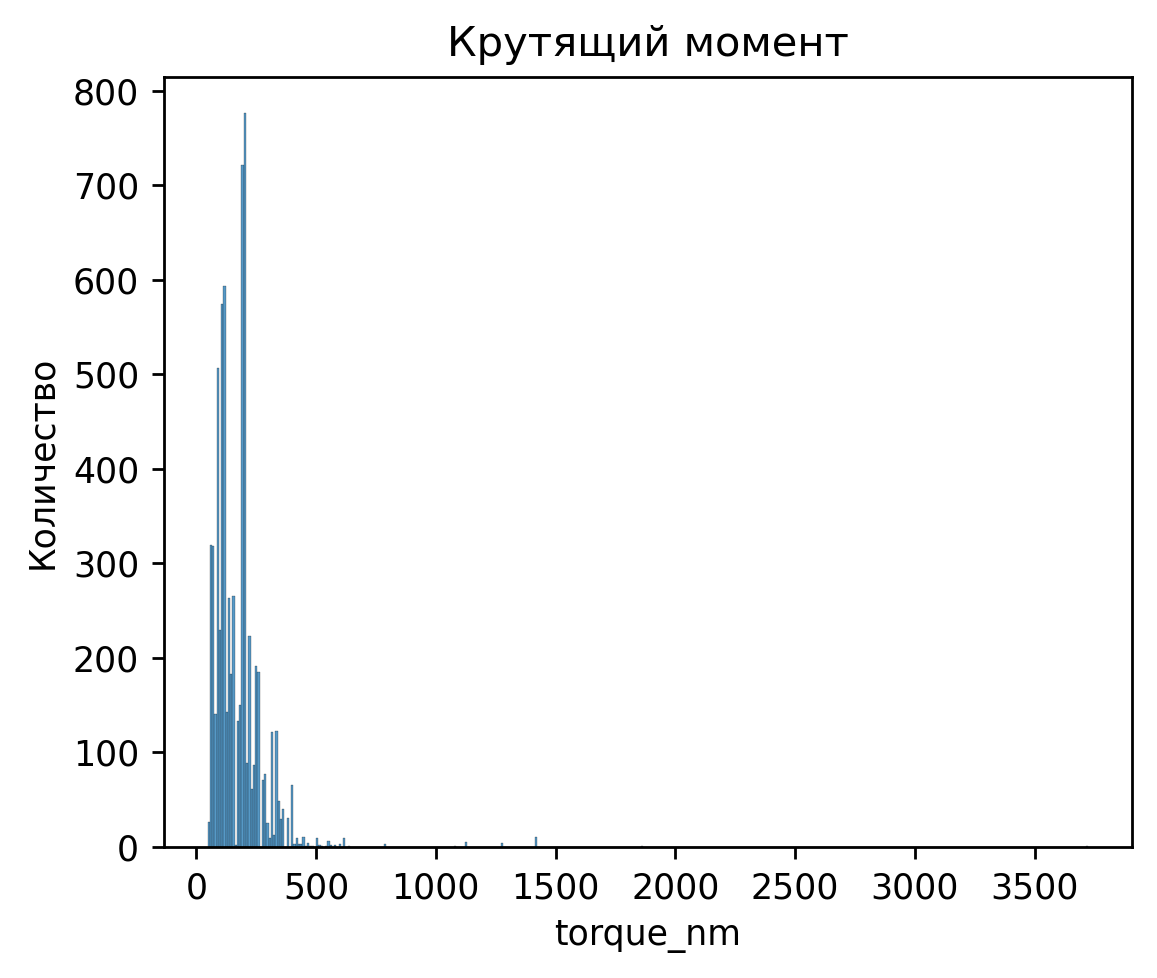

---------------------------------------------------
Ассимметрия равна 1.4682168428229327
Эксцесс равен 18.749334157490512
---------------------------------------------------


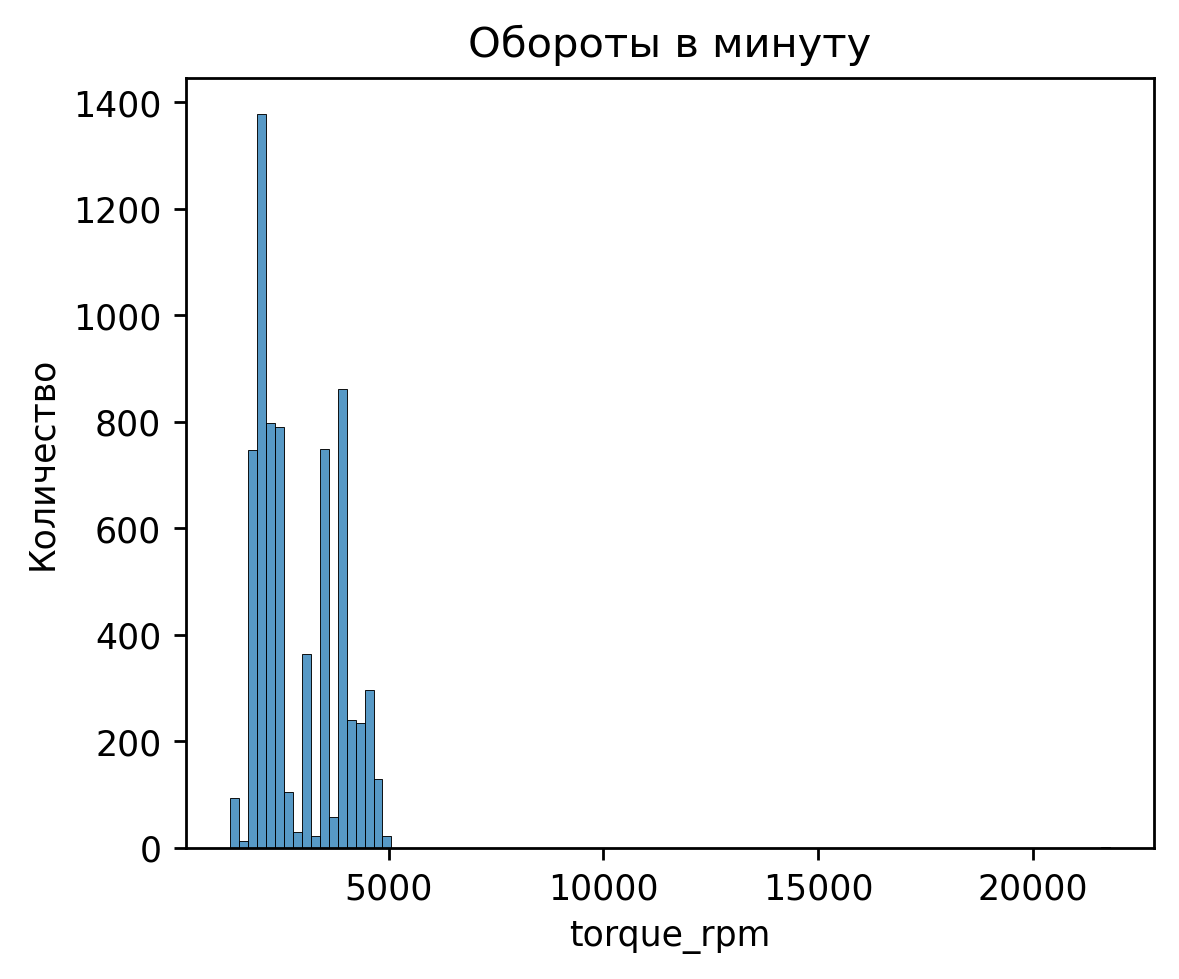

---------------------------------------------------
Ассимметрия равна 1.2246559086036934
Эксцесс равен 1.0009307428188428
---------------------------------------------------


In [66]:
#Посмотрим распределение с помощью histplot, также посмотрим ассиметрию и эксцесс

for col in df_num_columns.drop("selling_price", axis=1).columns:
    print("---------------------------------------------------")
    print(f"Ассимметрия равна {df_num_columns[col].skew()}")
    print(f"Эксцесс равен {df_num_columns[col].kurt()}")
    print("---------------------------------------------------")
    fig = plt.figure(figsize=(5, 4), dpi=250)
    plt.title(dict_translate_features[col])
    plt.ylabel("Количество")
    sns.histplot(data=df_num_columns, x=col)
    plt.show()

In [67]:
#Прологорифмируем призннаки max_power, torque_nm, torque_rpm

In [68]:
print("---------------------------------------------------")
print(f"Ассимметрия равна {np.log1p(df_num_columns["max_power"]).skew()}")
print(f"Эксцесс равен {np.log1p(df_num_columns["max_power"]).kurt()}")
print("---------------------------------------------------")
fig = plt.figure(figsize=(5, 4), dpi=250)
plt.title(dict_translate_features["max_power"])
plt.ylabel("Количество")
sns.histplot(x=np.log1p(df_num_columns["max_power"]))
plt.show()

---------------------------------------------------
Ассимметрия равна 0.26359513724573613
Эксцесс равен 0.668502212885707
---------------------------------------------------


In [69]:
print("---------------------------------------------------")
print(f"Ассимметрия равна {np.log1p(df_num_columns["torque_nm"]).skew()}")
print(f"Эксцесс равен {np.log1p(df_num_columns["torque_nm"]).kurt()}")
print("---------------------------------------------------")
fig = plt.figure(figsize=(5, 4), dpi=250)
plt.title(dict_translate_features["torque_nm"])
plt.ylabel("Количество")
sns.histplot(x=np.log1p(df_num_columns["torque_nm"]))
plt.show()

---------------------------------------------------
Ассимметрия равна 0.2528272005974629
Эксцесс равен 0.5145490831795954
---------------------------------------------------


---------------------------------------------------
Ассимметрия равна 0.2290056538534543
Эксцесс равен -1.1441105955168103
---------------------------------------------------


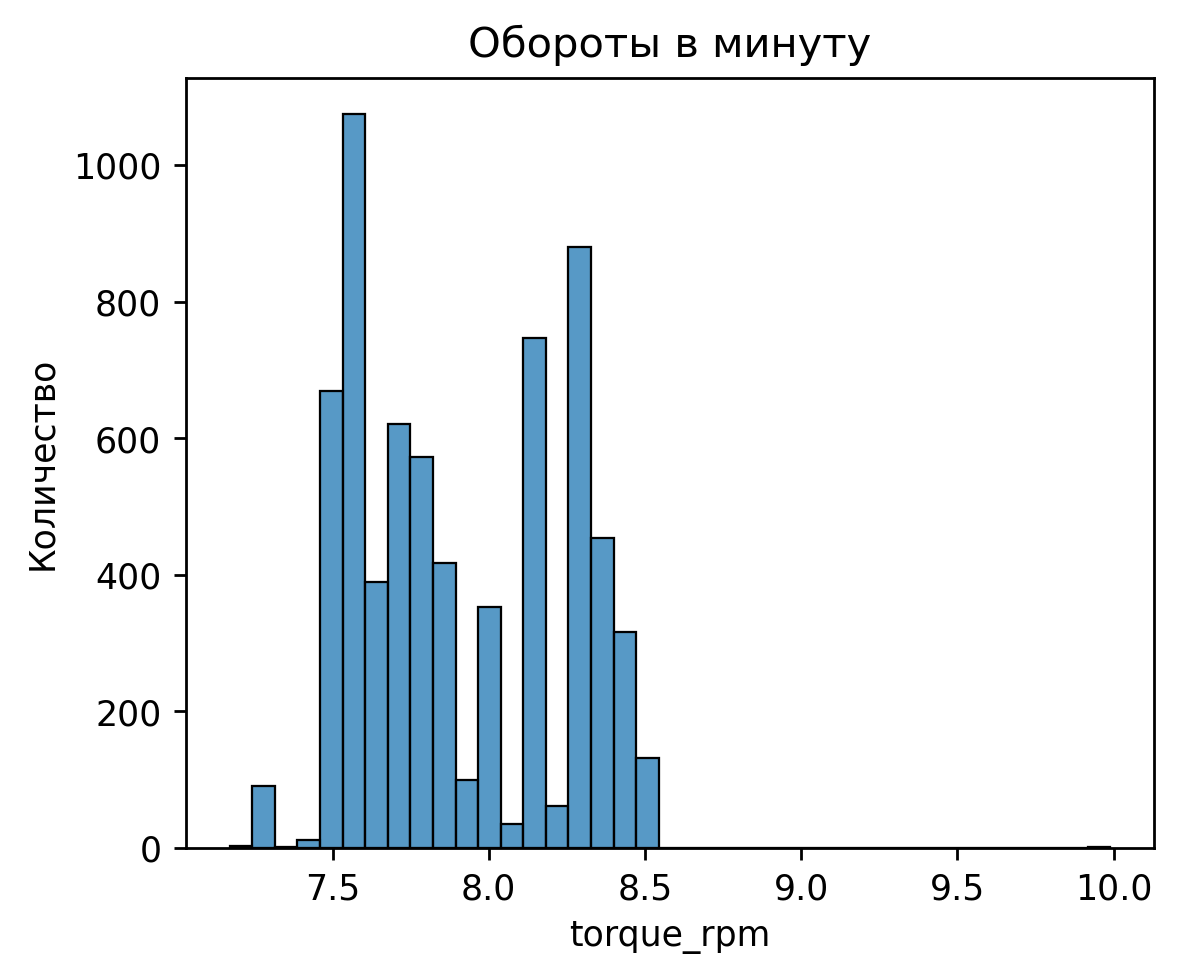

In [70]:
print("---------------------------------------------------")
print(f"Ассимметрия равна {np.log1p(df_num_columns["torque_rpm"]).skew()}")
print(f"Эксцесс равен {np.log1p(df_num_columns["torque_rpm"]).kurt()}")
print("---------------------------------------------------")
fig = plt.figure(figsize=(5, 4), dpi=250)
plt.title(dict_translate_features["torque_rpm"])
plt.ylabel("Количество")
sns.histplot(x=np.log1p(df_num_columns["torque_rpm"]))
plt.show()

In [71]:
full_df["max_power"] = np.log1p(df_num_columns["max_power"])
full_df["torque_nm"] = np.log1p(df_num_columns["torque_nm"])
full_df["torque_rpm"] = np.log1p(df_num_columns["torque_rpm"])
print("У даннных колонок поменяли распределение!")

У даннных колонок поменяли распределение!


In [72]:
full_df.nunique()

year                              29
selling_price                    677
km_driven                        921
seats                              9
mileage                          394
max_power                        324
torque_nm                        249
torque_rpm                        82
engine                           121
fuel_Diesel                        2
fuel_LPG                           2
fuel_Petrol                        2
seller_type_Individual             2
seller_type_Trustmark Dealer       2
transmission_Manual                2
owner_Fourth & Above Owner         2
owner_Second Owner                 2
owner_Test Drive Car               2
owner_Third Owner                  2
brand_mte                       6923
dtype: int64

### Анализ корреляции

In [73]:
#Посмотрим мультиколлениарность, через тепловую карту
fig = plt.figure(figsize=(15, 15), dpi=250)
sns.heatmap(full_df.corr(), annot=True, linewidths=1)
plt.show()

In [74]:
#Видно, что корреляция между признаками есть
num_columns = full_df.drop("selling_price", axis=1).columns
dict_corr = dict()
for i in range(len(num_columns)):
    for j in range(i, len(num_columns)):
        if i != j:
            dict_corr[f"{num_columns[i]}-{num_columns[j]}"] = round(float(full_df[[num_columns[i], num_columns[j]]].corr().iloc[0][1]), 3)

In [75]:
sorted_items = sorted(dict_corr.items(), key=lambda item: abs(item[1]))
sorted_items

[('torque_rpm-seller_type_Individual', -0.0),
 ('torque_rpm-owner_Fourth & Above Owner', -0.0),
 ('engine-owner_Third Owner', -0.001),
 ('fuel_LPG-owner_Test Drive Car', -0.002),
 ('seller_type_Trustmark Dealer-owner_Test Drive Car', -0.002),
 ('engine-owner_Fourth & Above Owner', -0.003),
 ('engine-seller_type_Trustmark Dealer', -0.004),
 ('owner_Fourth & Above Owner-owner_Test Drive Car', -0.004),
 ('torque_rpm-owner_Test Drive Car', 0.005),
 ('fuel_LPG-seller_type_Trustmark Dealer', -0.005),
 ('km_driven-brand_mte', 0.006),
 ('seats-owner_Fourth & Above Owner', 0.006),
 ('torque_rpm-owner_Third Owner', 0.007),
 ('fuel_Petrol-owner_Fourth & Above Owner', 0.007),
 ('seats-owner_Third Owner', -0.008),
 ('mileage-seller_type_Trustmark Dealer', -0.008),
 ('owner_Test Drive Car-owner_Third Owner', -0.008),
 ('year-engine', 0.01),
 ('torque_nm-owner_Second Owner', -0.01),
 ('seller_type_Trustmark Dealer-owner_Fourth & Above Owner', -0.01),
 ('fuel_Diesel-owner_Fourth & Above Owner', -0.011

In [76]:
#Удалим колонки fuel_Petrol и fuel_Diesel
full_df.drop(["fuel_Petrol", "fuel_Diesel"], axis=1, inplace=True)
print("Колонки fuel_Petrol и fuel_Diesel были успешно удалёны!")

Колонки fuel_Petrol и fuel_Diesel были успешно удалёны!


In [77]:
#Видно, что корреляция между признаками есть
num_columns = full_df.drop("selling_price", axis=1).columns
dict_corr = dict()
for i in range(len(num_columns)):
    for j in range(i, len(num_columns)):
        if i != j:
            dict_corr[f"{num_columns[i]}-{num_columns[j]}"] = round(float(full_df[[num_columns[i], num_columns[j]]].corr().iloc[0][1]), 3)

In [78]:
sorted_items = sorted(dict_corr.items(), key=lambda item: abs(item[1]))
sorted_items

[('torque_rpm-seller_type_Individual', -0.0),
 ('torque_rpm-owner_Fourth & Above Owner', -0.0),
 ('engine-owner_Third Owner', -0.001),
 ('fuel_LPG-owner_Test Drive Car', -0.002),
 ('seller_type_Trustmark Dealer-owner_Test Drive Car', -0.002),
 ('engine-owner_Fourth & Above Owner', -0.003),
 ('engine-seller_type_Trustmark Dealer', -0.004),
 ('owner_Fourth & Above Owner-owner_Test Drive Car', -0.004),
 ('torque_rpm-owner_Test Drive Car', 0.005),
 ('fuel_LPG-seller_type_Trustmark Dealer', -0.005),
 ('km_driven-brand_mte', 0.006),
 ('seats-owner_Fourth & Above Owner', 0.006),
 ('torque_rpm-owner_Third Owner', 0.007),
 ('seats-owner_Third Owner', -0.008),
 ('mileage-seller_type_Trustmark Dealer', -0.008),
 ('owner_Test Drive Car-owner_Third Owner', -0.008),
 ('year-engine', 0.01),
 ('torque_nm-owner_Second Owner', -0.01),
 ('seller_type_Trustmark Dealer-owner_Fourth & Above Owner', -0.01),
 ('seats-owner_Test Drive Car', -0.012),
 ('fuel_LPG-seller_type_Individual', 0.012),
 ('seats-owner_S

In [79]:
full_df.isna().sum()

year                            0
selling_price                   0
km_driven                       0
seats                           0
mileage                         0
max_power                       0
torque_nm                       0
torque_rpm                      0
engine                          0
fuel_LPG                        0
seller_type_Individual          0
seller_type_Trustmark Dealer    0
transmission_Manual             0
owner_Fourth & Above Owner      0
owner_Second Owner              0
owner_Test Drive Car            0
owner_Third Owner               0
brand_mte                       0
dtype: int64

In [80]:
check_VIF(full_df.drop("selling_price", axis=1))

                                VIF
year                          2.380
km_driven                     1.696
seats                         2.248
mileage                       2.995
max_power                     5.351
torque_nm                     7.738
torque_rpm                    3.152
engine                        5.245
fuel_LPG                      1.014
seller_type_Individual        1.144
seller_type_Trustmark Dealer  1.042
transmission_Manual           1.327
owner_Fourth & Above Owner    1.111
owner_Second Owner            1.271
owner_Test Drive Car          1.015
owner_Third Owner             1.221
brand_mte                     1.635


### Генерация признаков
- Добавляение признаков с помощью PolynomialFeature
- Добавление только полиномилаьных признаков без их коомбинации, как в PolynomialFeatures
- Добавление только вещественных полиномиальных признаков
- Добавление признаков из разлиных функций(логарифм, дисперсия, синусы, косинусы, коомбинации функции и функций полиномов)

In [81]:
X, y = full_df.drop("selling_price", axis=1), full_df["selling_price"]

In [82]:
df_one_columns = full_df[full_df.nunique()[full_df.nunique() == 2].index]
df_poly_transform_columns =  full_df[full_df.nunique()[full_df.nunique() != 2].index]

In [83]:
X, y = df_poly_transform_columns.drop("selling_price", axis=1), df_poly_transform_columns["selling_price"]

In [88]:
#Первый эксперемент будет сделан с помощью встроенного трансформера полиномиальных признаков
cv = KFold(n_splits=10, shuffle=True, random_state=42)

train_errors_list_1, test_errors_list_1, val_errors_list_1, r_2_errors_list = [], [], [], []
for degree in range(1, 7):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    transfrom = PolynomialFeatures(degree=degree, include_bias=True)
    X_train_poly = transfrom.fit_transform(X_train)
    X_test_poly = transfrom.transform(X_test)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_test_scaled = scaler.transform(X_test_poly)

    print(f"Количество признаков: {X_train_scaled.shape[1]}")

    model = Lasso(alpha=0.02)
    model.fit(X_train_scaled, y_train)

    train_errors_list_1.append(round(MSE(y_train, model.predict(X_train_scaled)), 4))
    test_errors_list_1.append(round(MSE(y_test, model.predict(X_test_scaled)), 4))


    pipe = Pipeline([("poly", PolynomialFeatures(degree=degree, include_bias=False)),
                    ("scaler", StandardScaler()), 
                    ("model", Lasso(alpha=0.02))])
    cross_validate = cross_val_score(estimator=pipe, X=X, y=y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

    val_errors_list_1.append(round(-float(np.mean(cross_validate)), 4))

    r_2 = round(1 - (-float(np.mean(cross_validate)) / y.var()), 4)
    r_2_errors_list.append(r_2)

Количество признаков: 10
Количество признаков: 55
Количество признаков: 220
Количество признаков: 715
Количество признаков: 2002
Количество признаков: 5005


In [86]:
#Lasso = 0.03
print(f"Ошибки на тренировочных данных: {train_errors_list_1}")
print(f"Ошибки на тестовых данных: {test_errors_list_1}")
print(f"Ошибки на усредненной валидации: {val_errors_list_1}")
print(f"Ошибки r^2: {r_2_errors_list}")
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.plot(list(range(1, 7)), train_errors_list_1, marker='o', linestyle='-', color='b', label='Ошибка на обучении (Train)')
plt.plot(list(range(1, 7)), test_errors_list_1, marker='o', linestyle='-', color='orange', label='Ошибка на тесте (Test)')
plt.plot(list(range(1, 7)), val_errors_list_1, marker='o', linestyle='-', color='green', label='Ошибка на кросс валидации (Cross_validate)')
plt.title('Эксперимент 1: Полный PolynomialFeatures', fontsize=14, fontweight='bold')
plt.xlabel('Степень полинома', fontsize=12)
plt.ylabel('Ошибка (MSE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

Ошибки на тренировочных данных: [0.0951, 0.0925, 0.0918, 0.0912, 0.0907, 0.0903]
Ошибки на тестовых данных: [0.0962, 0.0933, 0.093, 0.0921, 0.0916, 0.0912]
Ошибки на усредненной валидации: [0.096, 0.093, 0.0924, 0.0917, 0.0913, 0.0909]
Ошибки r^2: [0.8353, 0.8403, 0.8414, 0.8426, 0.8432, 0.8439]


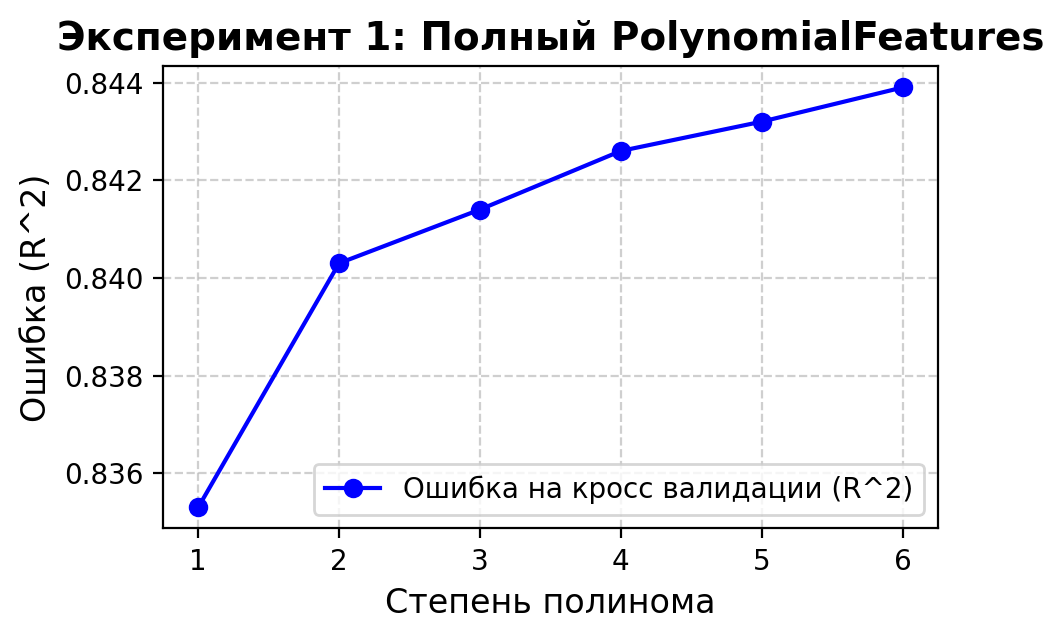

In [87]:
#Lasso = 0.03cc
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.plot(list(range(1, 7)), r_2_errors_list, marker='o', linestyle='-', color='b', label='Ошибка на кросс валидации (R^2)')
plt.title('Эксперимент 1: Полный PolynomialFeatures', fontsize=14, fontweight='bold')
plt.xlabel('Степень полинома', fontsize=12)
plt.ylabel('Ошибка (R^2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

Ошибки на тренировочных данных: [0.0928, 0.0912, 0.0904, 0.0896, 0.0892, 0.0889]
Ошибки на тестовых данных: [0.0944, 0.0922, 0.0916, 0.0906, 0.0902, 0.0899]
Ошибки на усредненной валидации: [0.0937, 0.0918, 0.0911, 0.0903, 0.0898, 0.0896]
Ошибки r^2: [0.8392, 0.8425, 0.8437, 0.8451, 0.8458, 0.8462]


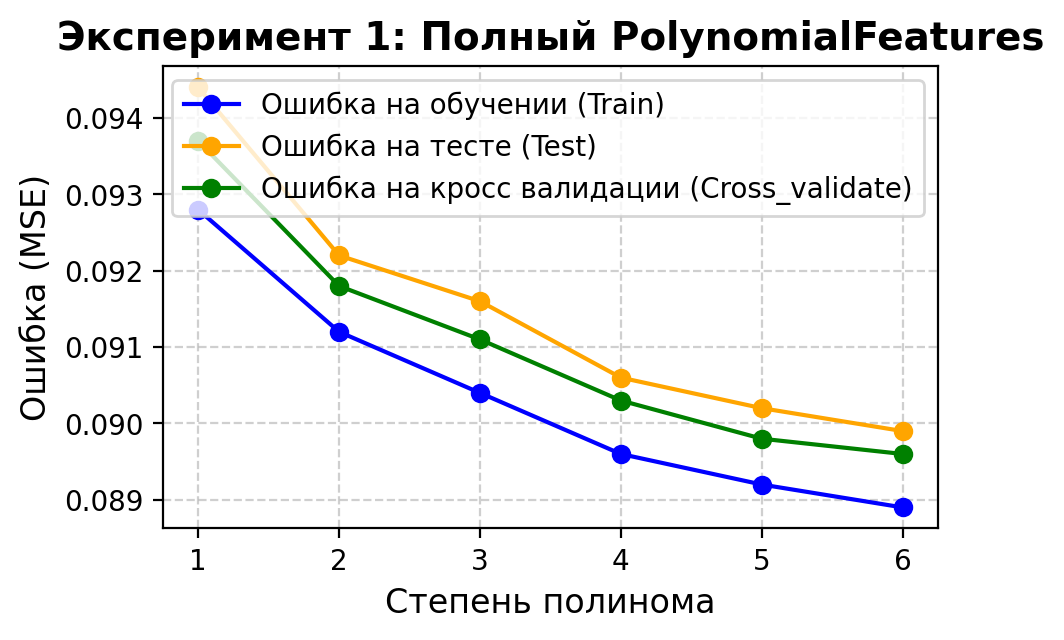

In [89]:
#Lasso = 0.02
print(f"Ошибки на тренировочных данных: {train_errors_list_1}")
print(f"Ошибки на тестовых данных: {test_errors_list_1}")
print(f"Ошибки на усредненной валидации: {val_errors_list_1}")
print(f"Ошибки r^2: {r_2_errors_list}")
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.plot(list(range(1, 7)), train_errors_list_1, marker='o', linestyle='-', color='b', label='Ошибка на обучении (Train)')
plt.plot(list(range(1, 7)), test_errors_list_1, marker='o', linestyle='-', color='orange', label='Ошибка на тесте (Test)')
plt.plot(list(range(1, 7)), val_errors_list_1, marker='o', linestyle='-', color='green', label='Ошибка на кросс валидации (Cross_validate)')
plt.title('Эксперимент 1: Полный PolynomialFeatures', fontsize=14, fontweight='bold')
plt.xlabel('Степень полинома', fontsize=12)
plt.ylabel('Ошибка (MSE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

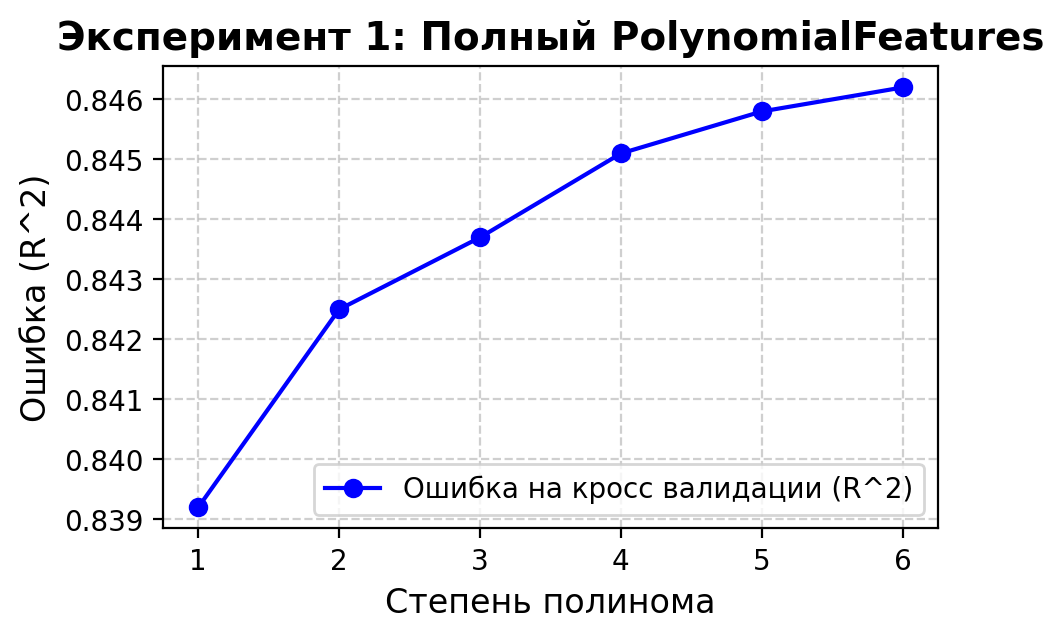

In [90]:
#Lasso = 0.02
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.plot(list(range(1, 7)), r_2_errors_list, marker='o', linestyle='-', color='b', label='Ошибка на кросс валидации (R^2)')
plt.title('Эксперимент 1: Полный PolynomialFeatures', fontsize=14, fontweight='bold')
plt.xlabel('Степень полинома', fontsize=12)
plt.ylabel('Ошибка (R^2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

In [ ]:
#Lasso = 0.01
print(f"Ошибки на тренировочных данных: {train_errors_list_1}")
print(f"Ошибки на тестовых данных: {test_errors_list_1}")
print(f"Ошибки на усредненной валидации: {val_errors_list_1}")
print(f"Ошибки r^2: {r_2_errors_list}")
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.plot(list(range(1, 7)), train_errors_list_1, marker='o', linestyle='-', color='b', label='Ошибка на обучении (Train)')
plt.plot(list(range(1, 7)), test_errors_list_1, marker='o', linestyle='-', color='orange', label='Ошибка на тесте (Test)')
plt.plot(list(range(1, 7)), val_errors_list_1, marker='o', linestyle='-', color='green', label='Ошибка на кросс валидации (Cross_validate)')
plt.title('Эксперимент 1: Полный PolynomialFeatures', fontsize=14, fontweight='bold')
plt.xlabel('Степень полинома', fontsize=12)
plt.ylabel('Ошибка (MSE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.plot(list(range(1, 7)), r_2_errors_list, marker='o', linestyle='-', color='b', label='Ошибка на кросс валидации (R^2)')
plt.title('Эксперимент 1: Полный PolynomialFeatures', fontsize=14, fontweight='bold')
plt.xlabel('Степень полинома', fontsize=12)
plt.ylabel('Ошибка (R^2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

In [ ]:
#Lasso = 0
print(f"Ошибки на тренировочных данных: {train_errors_list_1}")
print(f"Ошибки на тестовых данных: {test_errors_list_1}")
print(f"Ошибки на усредненной валидации: {val_errors_list_1}")
print(f"Ошибки r^2: {r_2_errors_list}")
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.plot(list(range(1, 7)), train_errors_list_1, marker='o', linestyle='-', color='b', label='Ошибка на обучении (Train)')
plt.plot(list(range(1, 7)), test_errors_list_1, marker='o', linestyle='-', color='orange', label='Ошибка на тесте (Test)')
plt.plot(list(range(1, 7)), val_errors_list_1, marker='o', linestyle='-', color='green', label='Ошибка на кросс валидации (Cross_validate)')
plt.title('Эксперимент 1: Полный PolynomialFeatures', fontsize=14, fontweight='bold')
plt.xlabel('Степень полинома', fontsize=12)
plt.ylabel('Ошибка (MSE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.plot(list(range(1, 7)), r_2_errors_list, marker='o', linestyle='-', color='b', label='Ошибка на кросс валидации (R^2)')
plt.title('Эксперимент 1: Полный PolynomialFeatures', fontsize=14, fontweight='bold')
plt.xlabel('Степень полинома', fontsize=12)
plt.ylabel('Ошибка (R^2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

In [ ]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

train_errors_list_2, test_errors_list_2, val_errors_list_2, r_2_errors_list_2 = [], [], [], []
X_copy = X.copy()
for degree in range(1, 11):
    if degree != 1:
        for col in X.columns:
            X_copy[f"{col}_{degree}"] = X[col]**degree
            
    X_train, X_test, y_train, y_test = train_test_split(X_copy, y, test_size=0.2, shuffle=True, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Количество признаков: {X_train_scaled.shape[1]}")

    model = Lasso(alpha=0.01)
    model.fit(X_train_scaled, y_train)

    train_errors_list_2.append(round(MSE(y_train, model.predict(X_train_scaled)), 4))
    test_errors_list_2.append(round(MSE(y_test, model.predict(X_test_scaled)), 4))

    pipe = Pipeline([("scaler", StandardScaler()), ("model", Lasso(alpha=0))])
    cross_validate = cross_val_score(estimator=pipe, X=X_copy, y=y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

    val_errors_list_2.append(round(-float(np.mean(cross_validate)), 4))

    r_2 = round(1 - (-float(np.mean(cross_validate)) / y.var()), 4)
    r_2_errors_list_2.append(r_2)

In [ ]:
print(f"Ошибки на тренировочных данных: {train_errors_list_2}")
print(f"Ошибки на тестовых данных: {test_errors_list_2}")
print(f"Ошибки на усредненной валидации: {val_errors_list_2}")
print(f"Ошибки r^2: {r_2_errors_list_2}")
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.plot(list(range(1, 11)), train_errors_list_2, marker='o', linestyle='-', color='b', label='Ошибка на обучении (Train)')
plt.plot(list(range(1, 11)), test_errors_list_2, marker='o', linestyle='-', color='orange', label='Ошибка на тесте (Test)')
plt.plot(list(range(1, 11)), val_errors_list_2, marker='o', linestyle='-', color='green', label='Ошибка на кросс валидации (Cross_validate)')
plt.title('Эксперимент 2: Ручное добавление признаков', fontsize=14, fontweight='bold')
plt.xlabel('Степень полинома', fontsize=12)
plt.ylabel('Ошибка (MSE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

### Результат
- Добавим признаки 3 степени с помощью PolynomualFeatures, после чего будем подбирать гиперпараметры

In [ ]:
X, y = full_df.drop("selling_price", axis=1), full_df["selling_price"]

In [112]:
pipe = Pipeline([("poly", PolynomialFeatures(degree=4, include_bias=False)),
                 ("scaler", StandardScaler()),
                ("model", ElasticNet(max_iter=5000))])

param_grid = {
    "model__alpha": [0.0001, 0.0005, 0.001],
    "model__l1_ratio": [0.0001, 0.0005, 0.001]
}

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)

In [113]:
%%time

grid.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: total: 47.1 s
Wall time: 2min 51s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=4,
                                                           include_bias=False)),
                                       ('scaler', StandardScaler()),
                                       ('model', ElasticNet(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.0001, 0.0005, 0.001],
                         'model__l1_ratio': [0.0001, 0.0005, 0.001]},
             scoring='neg_mean_squared_error', verbose=1)

In [991]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'model__alpha': 0.1, 'model__l1_ratio': 0.25, 'poly__degree': 4}
Лучший MSE: 0.08985634201621756


In [97]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'model__alpha': 0.05, 'model__l1_ratio': 0.1}
Лучший MSE: 0.08885000008686275


In [102]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'model__alpha': 0.02, 'model__l1_ratio': 0.01}
Лучший MSE: 0.08224563333688086


In [108]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'model__alpha': 0.005, 'model__l1_ratio': 0.003}
Лучший MSE: 0.08005809317365034


In [111]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'model__alpha': 0.001, 'model__l1_ratio': 0.001}
Лучший MSE: 0.07928843553300327


In [114]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'model__alpha': 0.001, 'model__l1_ratio': 0.0001}
Лучший MSE: 0.07928645236655693


In [ ]:
#Обучим модель
X, y = full_df.drop("selling_price", axis=1), full_df["selling_price"]

In [138]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)

MSE_test_error, MAE_test_error = [], []
i = 0
for train_index, val_index in cv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    transfrom = PolynomialFeatures(degree=4, include_bias=False)
    X_train_poly = transfrom.fit_transform(X_train)
    X_val_poly = transfrom.transform(X_val)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_val_scaled = scaler.transform(X_val_poly)
    print(i)
    model = ElasticNet(alpha=0.001, l1_ratio=0.0001, max_iter=5000)
    model.fit(X_train_scaled, y_train)

    y_true = np.exp(y_val)
    y_pred = np.exp(model.predict(X_val_scaled))

    MSE_test_error.append(MSE(y_true, y_pred))
    MAE_test_error.append(MAE(y_true, y_pred))
    i += 1

0
1
2
3
4
5
6
7
8
9


In [139]:
print(f"Средняя цена автомобиля: {round(float(np.mean(np.exp(y))), 4)}")
print(f"RMSE: {round((float(np.mean(MSE_test_error))**0.5), 4)}")
print(f"MAE: {round(float(np.mean(MAE_test_error)), 4)}")

Средняя цена автомобиля: 517271.6785
RMSE: 204035.8318
MAE: 101034.9708


In [140]:
r_2_test_error = []
i = 0
for train_index, val_index in cv.split(X):
    r_2 = 1 - (MSE_test_error[i] / np.exp(y.iloc[val_index]).var())
    r_2_test_error.append(r_2)

In [141]:
print(f"Средний R^2: {round(float(np.mean(r_2_test_error)), 3)}")

Средний R^2: 0.861


In [209]:
#Сделаем предсказание с помощью метода KNN

cv = KFold(n_splits=15, random_state=42, shuffle=True)

MSE_test_error_knn, MAE_test_error_knn = [], []
i = 0
for train_index, val_index in cv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    transfrom = PolynomialFeatures(degree=4, include_bias=False)
    X_train_poly = transfrom.fit_transform(X_train)
    X_val_poly = transfrom.transform(X_val)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_val_scaled = scaler.transform(X_val_poly)
    print(i)
    model = KNeighborsRegressor(weights="distance", n_jobs=-1)
    model.fit(X_train_scaled, y_train)

    y_true = np.exp(y_val)
    y_pred = np.exp(model.predict(X_val_scaled))

    MSE_test_error_knn.append(MSE(y_true, y_pred))
    MAE_test_error_knn.append(MAE(y_true, y_pred))
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [210]:
print(f"Средняя цена автомобиля: {round(float(np.mean(np.exp(y))), 4)}")
print(f"RMSE: {round((float(np.mean(MSE_test_error_knn))**0.5), 4)}")
print(f"MAE: {round(float(np.mean(MAE_test_error_knn)), 4)}")

Средняя цена автомобиля: 517271.6785
RMSE: 256077.9961
MAE: 110810.3894


In [148]:
r_2_test_error_knn = []
i = 0
for train_index, val_index in cv.split(X):
    r_2 = 1 - (MSE_test_error_knn[i] / np.exp(y.iloc[val_index]).var())
    r_2_test_error_knn.append(r_2)

In [149]:
print(f"Средний R^2: {round(float(np.mean(r_2_test_error_knn)), 3)}")

Средний R^2: 0.686


In [151]:
#Обучим модель
X, y = full_df.drop("selling_price", axis=1), full_df["selling_price"]

In [202]:
#Подберем гиперпараметры для KNN

pipe = Pipeline([("poly", PolynomialFeatures(degree=4, include_bias=False)),
                ("scaler", StandardScaler()),
                ("model", KNeighborsRegressor())])

param_grid = {
    "model__n_neighbors": [5],
    "model__p": [2],
    "model__weights": ["distance"]
}

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=10, verbose=1, scoring="neg_mean_squared_error", n_jobs=-1)

In [203]:
%%time

grid.fit(X,y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: total: 688 ms
Wall time: 7.58 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=4,
                                                           include_bias=False)),
                                       ('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [5], 'model__p': [2],
                         'model__weights': ['distance']},
             scoring='neg_mean_squared_error', verbose=1)

In [204]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'model__n_neighbors': 5, 'model__p': 2, 'model__weights': 'distance'}
Лучший MSE: 0.1018420051092418


In [267]:
#Обучим модель
X, y = full_df.drop("selling_price", axis=1), full_df["selling_price"]

# Ручная реализация класса KNNRegressor

In [426]:
class KNNRegressor:
    def __init__(self, n_neighbors=5, p=2, weights="uniform", h=1):
        self.n_neighbors = n_neighbors
        self.p = p
        self.weights = weights
        self.h = h

    @staticmethod
    def _kernel(distance, h):
        const = 1 / (np.sqrt(2 * np.pi))
        h_safe = h if h > 0 else 1e-8
        power = (-1/2) * ((distance)**2) / h_safe**2
        return const * np.exp(power)

    def fit(self, X, y):
        self.X, self.y = X, y

    def predict(self, X):
        n_neigs = []
        for i in range(len(X)):
            n_neigs.append(((((self.X - X.iloc[i])**self.p).sum(axis=1))**(1/self.p)).sort_values()[:self.n_neighbors])

        predicts = []
        if self.weights == "uniform":
            for n_neig in n_neigs:
                predicts.append(float(self.y.loc[n_neig.index].sum() / len(n_neig)))
        elif self.weights == "distance":
            for n_neig in n_neigs:
                predicts.append(float((self.y.loc[n_neig.index] @ (1 / n_neig)) / sum(1 / n_neig)))
        elif self.weights == "kernel":
            for n_neig in n_neigs:
                predicts.append(float( _kernel(self.y.loc[n_neig.index], h=self.h) @ self.y.loc[n_neig.index] / sum(_kernel(self.y.loc[n_neig.index], h=self.h))))
        else:
            raise ValueError("Такого weights нет, выбирайте между (uniform, distance, kernel)")
                
        return predicts
                

In [447]:
model = KNNRegressor(weights = "distance", p=70)

In [448]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.1, random_state=42, shuffle=True)

In [449]:
model.fit(X_train, y_train)

In [450]:
MSE(model.predict(X_test), y_test)

0.13116562491184425

# Довольно хороший результат